# Inerpretation-Net Training

# Experiment 1: I-Net Performance for Different Algebras and Complexities
# Experiment 2: I-Net Performance Comparison for λ-Nets with Different Training Levels
# Experiment 3: I-Net Performance Comparison Different Training Data Sizes

## Specitication of Experiment Settings

In [1]:
#######################################################################################################################################
###################################################### CONFIG FILE ####################################################################
#######################################################################################################################################
sleep_time = 0 #minutes


config = {
    'data': {
        'd': 5, #degree
        'n': 1, #number of variables
        'sparsity': None,
        'sample_sparsity': None,
        'x_max': 1,
        'x_min': 0,
        'x_distrib': 'uniform', #'normal', 'uniform', 'beta', 'Gamma', 'laplace'
        'a_max': 100,
        'a_min': -100,
        'lambda_nets_total': 50000,
        'noise': 0.1,
        'noise_distrib': 'normal', #'normal', 'uniform', 'beta', 'Gamma', 'laplace'
        
        'same_training_all_lambda_nets': False,

        'fixed_seed_lambda_training': True,
        'fixed_initialization_lambda_training': False,
        'number_different_lambda_trainings': 1,
    },
    'lambda_net': {
        'epochs_lambda': 1000,
        'early_stopping_lambda': True,  #if early stopping is used, multi_epoch_analysis is deactivated
        'early_stopping_min_delta_lambda': 1e-4,
        'batch_lambda': 64,
        'dropout': 0,
        'lambda_network_layers': [5*'sparsity'],
        'optimizer_lambda': 'adam',
        'loss_lambda': 'mae',
        'number_of_lambda_weights': None,
        'lambda_dataset_size': 5000,
    },
    'i_net': {
        'optimizer': 'custom',#adam
        'inet_loss': 'mae',
        'inet_metrics': ['r2'],
        'dropout': 0.25,
        'dropout_output': 0,
        'epochs': 500,
        'early_stopping': True,
        'batch_size': 256,
        'dense_layers': [512, 1024],
        'convolution_layers': None,
        'lstm_layers': None,
        'interpretation_dataset_size': 50000,
                
        'interpretation_net_output_monomials': None, #(None, int)
        'interpretation_net_output_shape': None, #calculated automatically later
        'test_size': 100, #Float for fraction, Int for number
        
        'evaluate_with_real_function': False,
        'consider_labels_training': False,
                      
        'data_reshape_version': None, #default to 2 options:(None, 0,1 2)
        'nas': False,
        'nas_type': 'SEQUENTIAL', #options:(None, 'SEQUENTIAL', 'CNN', 'LSTM', 'CNN-LSTM', 'CNN-LSTM-parallel')      
        'nas_trials': 100,
    },
    'evaluation': {   
        'inet_holdout_seed_evaluation': False,
        
        #set if multi_epoch_analysis should be performed
        'multi_epoch_analysis': True,
        'each_epochs_save_lambda': 100,
        'epoch_start': 0, #use to skip first epochs in multi_epoch_analysis
        
        #set if samples analysis should be performed
        'samples_list': None,#[100, 500, 750, 1000, 2500, 5000, 7500, 10000, 15000, 20000, 25000, 28125] 
       
        'random_evaluation_dataset_size': 500,
    },
    'computation':{
        'n_jobs': -3,
        'use_gpu': False,
        'gpu_numbers': '0',
        'RANDOM_SEED': 42,   
    }
}

## Imports

In [2]:
#######################################################################################################################################
########################################### IMPORT GLOBAL VARIABLES FROM CONFIG #######################################################
#######################################################################################################################################
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

In [3]:
#######################################################################################################################################
##################################################### IMPORT LIBRARIES ################################################################
#######################################################################################################################################
from itertools import product       
from tqdm import tqdm_notebook as tqdm
import pickle
import numpy as np
import pandas as pd
import scipy as sp
import timeit
import psutil

from functools import reduce
from more_itertools import random_product 
from sklearn.preprocessing import Normalizer

import sys
import os
import shutil

import logging

from prettytable import PrettyTable
import colored
import math

import time
from datetime import datetime
from collections.abc import Iterable


from joblib import Parallel, delayed

from scipy.integrate import quad

from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, KFold, ParameterGrid, ParameterSampler
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score, mean_absolute_error, r2_score

from similaritymeasures import frechet_dist, area_between_two_curves, dtw
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.utils import plot_model
from IPython.display import Image

import keras.backend as K
from livelossplot import PlotLossesKerasTF
from keras_tqdm import TQDMNotebookCallback
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from matplotlib import pyplot as plt
import seaborn as sns


import tensorflow as tf
import random 


import warnings


from IPython.display import display, Math, Latex, clear_output


In [4]:
sys.path.append('..')

from utilities.InterpretationNet import *
from utilities.LambdaNet import *
from utilities.metrics import *
from utilities.utility_functions import *

#from symbolic_metamodeling.pysymbolic.algorithms.symbolic_metamodeling import * 


In [5]:
#######################################################################################################################################
################################################### VARIABLE ADJUSTMENTS ##############################################################
#######################################################################################################################################
variables = 'abcdefghijklmnopqrstuvwxyz'[:n]

n_jobs = min((epochs_lambda//each_epochs_save_lambda+1, n_jobs)) if multi_epoch_analysis else min(len(samples_list), n_jobs) if samples_list!=None else 1

multi_epoch_analysis = False if early_stopping_lambda else multi_epoch_analysis #deactivate multi_epoch_analysis if early stopping is used

each_epochs_save_lambda = each_epochs_save_lambda if multi_epoch_analysis else epochs_lambda
epochs_save_range_lambda = range(epoch_start//each_epochs_save_lambda, epochs_lambda//each_epochs_save_lambda) if each_epochs_save_lambda == 1 else range(epoch_start//each_epochs_save_lambda, epochs_lambda//each_epochs_save_lambda+1) if multi_epoch_analysis else range(1,2)

data_reshape_version = 2 if data_reshape_version == None and (convolution_layers != None or lstm_layers != None or (nas and nas_type != 'SEQUENTIAL')) else data_reshape_version
#######################################################################################################################################
###################################################### SET VARIABLES + DESIGN #########################################################
#######################################################################################################################################

#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_numbers if use_gpu else ''

logging.getLogger('tensorflow').disabled = True

sns.set_style("darkgrid")
#np.set_printoptions(suppress=True)

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(RANDOM_SEED)
else:
    tf.set_random_seed(RANDOM_SEED)
    
    
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', 500)

warnings.filterwarnings('ignore')

In [6]:
#######################################################################################################################################
####################################################### CONFIG ADJUSTMENTS ############################################################
#######################################################################################################################################
config['evaluation']['multi_epoch_analysis'] = multi_epoch_analysis
config['evaluation']['each_epochs_save_lambda'] = each_epochs_save_lambda
config['i_net']['data_reshape_version'] = data_reshape_version

config['data']['sparsity'] = nCr(config['data']['n']+config['data']['d'], config['data']['d'])
config['data']['sample_sparsity'] = config['data']['sparsity'] if config['data']['sample_sparsity'] == None else config['data']['sample_sparsity']

config['i_net']['interpretation_net_output_shape'] = config['data']['sparsity'] if config['i_net']['interpretation_net_output_monomials'] is None else config['data']['sparsity']*config['i_net']['interpretation_net_output_monomials']+config['i_net']['interpretation_net_output_monomials']


transformed_layers = []
for layer in config['lambda_net']['lambda_network_layers']:
    if type(layer) == str:
        transformed_layers.append(layer.count('sparsity')*config['data']['sparsity'])
    else:
        transformed_layers.append(layer)
config['lambda_net']['lambda_network_layers'] = transformed_layers

layers_with_input_output = list(flatten([[config['data']['n']], config['lambda_net']['lambda_network_layers'], [1]]))
number_of_lambda_weights = 0
for i in range(len(layers_with_input_output)-1):
    number_of_lambda_weights += (layers_with_input_output[i]+1)*layers_with_input_output[i+1]  
config['lambda_net']['number_of_lambda_weights'] = number_of_lambda_weights
    
#######################################################################################################################################
################################################## UPDATE VARIABLES ###################################################################
#######################################################################################################################################
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])



initialize_LambdaNet_config_from_curent_notebook(config)
initialize_metrics_config_from_curent_notebook(config)
initialize_utility_functions_config_from_curent_notebook(config)
initialize_InterpretationNet_config_from_curent_notebook(config)


#######################################################################################################################################
###################################################### PATH + FOLDER CREATION #########################################################
#######################################################################################################################################
globals().update(generate_paths(path_type='interpretation_net'))
create_folders_inet()

#######################################################################################################################################
############################################################ SLEEP TIMER ##############################################################
#######################################################################################################################################
sleep_minutes(sleep_time)

In [7]:
print(path_identifier_interpretation_net_data)

print(path_identifier_lambda_net_data)


inet_dense512-1024-output_6_drop0.25e500b256_custom/lnets_50000_30-1000e_ES0.0001_64b_adam_mae_train_5000_diffX_1-FixSeed_42/var_1_d_5_sparsity_6_amin_-100_amax_100_xdist_uniform_noise_normal_0.1
lnets_50000_30-1000e_ES0.0001_64b_adam_mae_train_5000_diffX_1-FixSeed_42/var_1_d_5_sparsity_6_amin_-100_amax_100_xmin_0_xmax_1_xdist_uniform_noise_normal_0.1


In [8]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num XLA-GPUs Available: ", len(tf.config.experimental.list_physical_devices('XLA_GPU')))

Num GPUs Available:  0
Num XLA-GPUs Available:  0


## Utility functions

### Generate List of Monomial Identifiers

In [9]:
list_of_monomial_identifiers_extended = []
for i in tqdm(range((d+1)**n)):    
    monomial_identifier = dec_to_base(i, base = (d+1)).zfill(n) 
    list_of_monomial_identifiers_extended.append(monomial_identifier)

print('List length: ' + str(len(list_of_monomial_identifiers_extended)))
print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(nCr(n+d, d)))
print('Sparsity: ' + str(sparsity))
print(list_of_monomial_identifiers_extended)

list_of_monomial_identifiers = []
for monomial_identifier in tqdm(list_of_monomial_identifiers_extended):
    monomial_identifier_values = list(map(int, list(monomial_identifier)))
    if sum(monomial_identifier_values) <= d:
        list_of_monomial_identifiers.append(monomial_identifier)

print('List length: ' + str(len(list_of_monomial_identifiers)))
print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(nCr(n+d, d)))
print('Sparsity: ' + str(sparsity))
print(list_of_monomial_identifiers)


layers_with_input_output = list(flatten([[n], lambda_network_layers, [1]]))
number_of_lambda_weights = 0
for i in range(len(layers_with_input_output)-1):
    number_of_lambda_weights += (layers_with_input_output[i]+1)*layers_with_input_output[i+1]

  0%|          | 0/6 [00:00<?, ?it/s]

List length: 6
Number of monomials in a polynomial with 1 variables and degree 5: 6
Sparsity: 6
['0', '1', '2', '3', '4', '5']


  0%|          | 0/6 [00:00<?, ?it/s]

List length: 6
Number of monomials in a polynomial with 1 variables and degree 5: 6
Sparsity: 6
['0', '1', '2', '3', '4', '5']


## Load Data and Generate Datasets

In [10]:
def load_lambda_nets(index):
    
    if psutil.virtual_memory().percent > 80:
        raise SystemExit("Out of RAM!")
    
    directory = './data/weights/' + 'weights_' + path_identifier_lambda_net_data + '/'
    path_weights = directory + 'weights_epoch_' + str(index).zfill(3) + '.txt'
    path_X_data = directory + 'lambda_X_test_data.txt'
    path_y_data = directory + 'lambda_y_test_data.txt'        
    
    weight_data = pd.read_csv(path_weights, sep=",", header=None)
    weight_data = weight_data.sort_values(by=0).sample(frac=1, random_state=RANDOM_SEED)
    weight_data = weight_data.sort_values(by=0).sample(n=interpretation_dataset_size, random_state=RANDOM_SEED)
    
    lambda_X_test_data = pd.read_csv(path_X_data, sep=",", header=None)
    lambda_X_test_data = lambda_X_test_data.sort_values(by=0).sample(frac=1, random_state=RANDOM_SEED)
    lambda_X_test_data = lambda_X_test_data.sort_values(by=0).sample(n=interpretation_dataset_size, random_state=RANDOM_SEED)
    
    lambda_y_test_data = pd.read_csv(path_y_data, sep=",", header=None)
    lambda_y_test_data = lambda_y_test_data.sort_values(by=0).sample(frac=1, random_state=RANDOM_SEED)
    lambda_y_test_data = lambda_y_test_data.sort_values(by=0).sample(n=interpretation_dataset_size, random_state=RANDOM_SEED)
        
    lambda_nets = [None] * weight_data.shape[0]
    for i, (row_weights, row_lambda_X_test_data, row_lambda_y_test_data) in enumerate(zip(weight_data.values, lambda_X_test_data.values, lambda_y_test_data.values)):        
        lambda_net = LambdaNet(row_weights, row_lambda_X_test_data, row_lambda_y_test_data)
        lambda_nets[i] = lambda_net
                
    lambda_net_dataset = LambdaNetDataset(lambda_nets)
        
    return lambda_net_dataset
    

In [11]:
#LOAD DATA

parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='multiprocessing')
lambda_net_dataset_list = parallel(delayed(load_lambda_nets)((i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1) for i in epochs_save_range_lambda)  
del parallel

lambda_net_dataset = lambda_net_dataset_list[-1]


[Parallel(n_jobs=-3)]: Using backend MultiprocessingBackend with 22 concurrent workers.
[Parallel(n_jobs=-3)]: Done   1 out of   1 | elapsed:  1.9min finished


## Data Inspection

In [12]:
lambda_net_dataset.as_pandas().head()

,seed,0-target,1-target,2-target,3-target,4-target,5-target,0-lstsq_lambda,1-lstsq_lambda,2-lstsq_lambda,3-lstsq_lambda,4-lstsq_lambda,5-lstsq_lambda,0-lstsq_target,1-lstsq_target,2-lstsq_target,3-lstsq_target,4-lstsq_target,5-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,wb_81,wb_82,wb_83,wb_84,wb_85,wb_86,wb_87,wb_88,wb_89,wb_90
33553,1373158606,-0.690,-91.700,84.563,89.688,86.647,-87.301,-14.605,13.372,-18.702,-354.988,1028.692,-582.996,-0.692,-91.624,84.242,89.962,86.943,-87.635,-0.009,-0.227,0.162,0.035,3.920,3.930,0.024,-0.297,0.046,4.307,0.230,-0.088,-0.019,0.069,3.915,0.239,3.566,4.155,3.866,4.074,3.888,0.012,-0.102,-0.042,-0.404,-0.090,0.034,-0.291,-0.209,-0.233,0.000,0.000,1.080,1.098,-2.411,-1.810,1.278,0.000,1.081,-1.954,1.218,0.000,0.000,1.243,-1.960,1.133,-2.430,-1.891,-2.631,-2.233,-2.354,1.045,1.298,0.000,0.000,0.000,1.037,0.000,0.000,0.000,-0.254,-0.359,-1.131,-1.153,6.112,5.285,-0.987,-0.408,-1.204,4.830,-0.970,-0.352,-0.364,-1.000,5.301,-1.053,6.932,4.969,6.281,5.437,5.966,-1.257,-1.000,-0.261,-0.383,-0.059,-1.244,0.144,-0.258,-0.315,-1.421
9427,1373158606,44.776,-84.631,-59.775,50.673,75.106,45.766,45.906,-121.823,237.945,-859.440,1244.724,-486.666,44.764,-84.313,-61.617,54.759,71.126,47.200,-0.009,-0.227,0.118,0.073,-2.781,-3.249,4.440,-0.297,0.058,-2.737,4.663,-0.088,-0.019,4.474,-2.955,4.409,-3.650,-2.659,-2.605,-2.625,-3.224,0.036,0.007,-0.042,-0.404,-0.090,0.041,-0.291,-0.209,-0.233,0.000,0.000,-0.120,-0.079,1.480,1.472,-3.615,0.000,-0.067,1.541,-3.106,0.000,0.000,-3.589,1.475,-3.247,1.477,1.499,1.450,1.476,1.508,-0.047,-0.022,0.000,0.000,0.000,-0.052,0.000,0.000,0.000,-0.254,-0.359,-0.177,-0.214,3.384,3.996,14.788,-0.408,-0.251,3.143,12.795,-0.352,-0.364,14.636,3.469,13.424,4.753,3.232,3.355,3.258,3.678,-0.307,-0.044,-0.261,-0.383,-0.059,-0.330,0.144,-0.258,-0.315,-2.698
199,1373158606,-90.852,74.307,94.698,93.776,49.930,-73.983,-90.137,155.859,-775.191,2816.724,-3165.405,1185.067,-90.855,74.455,93.786,95.801,47.967,-73.280,-0.009,-0.227,-3.346,-3.337,3.854,3.751,3.916,-0.297,-3.307,4.203,4.064,-0.088,-0.019,3.937,3.825,-3.119,3.473,4.010,3.899,4.016,3.806,-3.278,-3.522,-0.042,-0.404,-0.090,-3.265,-0.291,-0.209,-0.233,0.000,0.000,3.156,3.138,-1.326,-1.374,-1.330,0.000,3.106,-1.299,-1.310,0.000,0.000,-1.312,-1.307,2.941,-1.341,-1.372,-1.333,-1.274,-1.359,3.087,3.300,0.000,0.000,0.000,3.071,0.000,0.000,0.000,-0.254,-0.359,-3.877,-4.076,4.140,4.231,3.908,-0.408,-4.151,3.851,3.767,-0.352,-0.364,3.872,4.158,-3.141,4.582,3.971,4.103,4.003,4.159,-4.270,-4.027,-0.261,-0.383,-0.059,-4.292,0.144,-0.258,-0.315,-2.344
12447,1373158606,87.789,47.981,66.870,2.825,-21.389,30.245,75.653,112.943,0.000,-0.000,0.000,-0.000,87.786,47.981,67.372,0.620,-18.272,28.828,-0.009,-0.227,0.131,0.082,3.627,3.543,0.110,-0.297,0.067,3.914,3.774,-0.088,-0.019,0.131,3.582,0.179,3.282,3.792,3.684,3.776,3.585,0.041,0.008,-0.042,-0.404,-0.090,0.047,-0.291,-0.209,-0.233,0.000,0.000,-0.131,-0.084,2.349,2.332,-0.110,0.000,-0.070,2.549,2.303,0.000,0.000,-0.131,2.361,-0.179,2.227,2.441,2.316,2.408,2.458,-0.047,-0.023,0.000,0.000,0.000,-0.052,0.000,0.000,0.000,-0.254,-0.359,-0.200,-0.225,3.141,3.196,-0.042,-0.408,-0.258,2.894,2.944,-0.352,-0.364,-0.042,3.114,-0.097,3.413,3.001,3.151,3.046,3.052,-0.310,-0.045,-0.261,-0.383,-0.059,-0.334,0.144,-0.258,-0.315,2.246
39489,1373158606,-71.041,-25.868,-88.470,12.459,30.622,79.037,-72.065,-47.854,81.648,-299.843,425.674,-190.524,-71.022,-26.130,-87.394,10.613,32.051,78.615,-0.009,-0.227,1.424,1.320,0.109,0.080,1.481,-0.297,1.253,1.627,1.584,-0.088,-0.019,1.487,0.079,1

In [13]:
lambda_net_dataset.as_pandas().describe()

,seed,0-target,1-target,2-target,3-target,4-target,5-target,0-lstsq_lambda,1-lstsq_lambda,2-lstsq_lambda,3-lstsq_lambda,4-lstsq_lambda,5-lstsq_lambda,0-lstsq_target,1-lstsq_target,2-lstsq_target,3-lstsq_target,4-lstsq_target,5-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,wb_81,wb_82,wb_83,wb_84,wb_85,wb_86,wb_87,wb_88,wb_89,wb_90
count,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000
mean,1373158606.000,0.331,-0.108,-0.021,0.005,0.162,0.208,0.053,0.009,6.406,-18.968,21.178,-8.730,0.331,-0.109,-0.015,-0.007,0.170,0.206,-0.009,-0.227,1.187,1.077,1.303,1.209,1.292,-0.297,1.039,2.097,2.301,-0.088,-0.019,1.353,1.216,1.420,0.916,2.154,1.418,2.067,1.102,0.950,0.869,-0.042,-0.404,-0.090,0.967,-0.291,-0.209,-0.233,0.000,0.000,0.208,0.237,0.280,0.292,0.273,0.000,0.235,1.199,0.597,0.000,0.000,0.252,0.339,0.163,0.346,0.813,0.224,0.044,0.487,0.258,0.513,0.000,0.000,0.000,0.226,0.000,0.000,0.000,-0.254,-0.359,-2.381,-2.425,2.509,2.615,-1.970,-0.408,-2.485,-0.024,-0.145,-0.352,-0.364,-1.979,2.492,-2.159,2.648,0.520,2.519,2.007,2.234,-2.509,-1.839,-0.261,-0.383,-0.059,-2.581,0.144,-0.258,-0.315,0.013
std,0.000,57.749,57.678,57.764,57.627,57.855,57.666,53.345,77.603,375.316,1184.947,1595.299,684.499,57.749,57.678,57.784,57.756,57.976,57.700,0.000,0.000,1.965,1.925,2.173,2.148,1.963,0.000,1.917,2.221,2.474,0.000,0.000,1.976,2.152,2.008,2.048,2.333,2.188,2.525,2.136,1.894,1.902,0.000,0.000,0.000,1.896,0.000,0.000,0.000,0.000,0.000,1.564,1.558,1.726,1.730,1.529,0.000,1.561,1.547,2.067,0.000,0.000,1.524,1.712,1.558,1.627,1.936,1.734,2.047,1.633,1.531,1.396,0.000,0.000,0.000,1.554,0.000,0.000,0.000,0.000,0.000,2.466,2.547,2.716,2.768,2.546,0.000,2.598,2.878,4.317,0.000,0.000,2.556,2.706,2.584,2.776,3.817,2.760,4.584,2.569,2.624,2.113,0.000,0.000,0.000,2.671,0.000,0.000,0.000,5.615
min,1373158606.000,-99.999,-99.997,-100.000,-99.998,-99.998,-99.999,-117.956,-333.987,-1813.519,-5361.312,-7058.661,-3216.009,-100.004,-100.383,-103.420,-111.579,-112.078,-104.717,-0.009,-0.227,-7.037,-8.124,-4.593,-6.150,-4.730,-0.297,-5.712,-6.027,-9.197,-0.088,-0.019,-4.610,-6.627,-3.597,-7.108,-7.979,-6.531,-8.560,-7.073,-6.863,-8.021,-0.042,-0.404,-0.090,-6.249,-0.291,-0.209,-0.233,0.000,0.000,-5.785,-5.559,-5.161,-5.233,-5.775,0.000,-5.092,-4.838,-9.424,0.000,0.000,-5.516,-5.239,-7.318,-5.113,-8.657,-5.226,-9.547,-6.111,-5.514,-6.047,0.000,0.000,0.000,-5.710,0.000,0.000,0.000,-0.254,-0.359,-16.634,-17.451,-18.286,-19.586,-18.364,-0.408,-16.912,-11.083,-15.751,-0.352,-0.364,-18.143,-14.840,-22.229,0.3

In [14]:
lambda_net_dataset.X_test_data_list[0][:10]

array([[0.43252904],
       [0.0587113 ],
       [0.90847031],
       [0.47212735],
       [0.77216556],
       [0.69190392],
       [0.17179775],
       [0.55014215],
       [0.60724935],
       [0.51445236]])

In [15]:
lambda_net_dataset.y_test_data_list[0][:10]

array([[-15.53396449],
       [ -5.85610282],
       [ 58.11293808],
       [-13.30246393],
       [ 27.12632105],
       [ 12.0890019 ],
       [-13.57538839],
       [ -7.15463617],
       [ -0.47046144],
       [-10.2629981 ]])

## Generate Datasets for Interpretation-Net training

In [16]:
#generate train, test and validation data for training

lambda_net_train_dataset_list = []
lambda_net_valid_dataset_list = []
lambda_net_test_dataset_list = []

for lambda_net_dataset in lambda_net_dataset_list:
    
    
    if inet_holdout_seed_evaluation:
        complete_seed_list = list(set(lambda_net_dataset.train_settings_list['seed']))#list(weight_data.iloc[:,1].unique())

        random.seed(RANDOM_SEED)
        
        if isinstance(test_size, float):
            test_size = int(len(complete_seed_list)-len(complete_seed_list)/(1/(1-test_size)))
        
        test_seeds = random.sample(complete_seed_list, test_size)
        lambda_net_test_dataset = lambda_net_dataset.get_lambda_nets_by_seed(test_seeds)
        complete_seed_list = list(set(complete_seed_list) - set(test_seeds))#complete_seed_list.remove(test_seeds)
        
        random.seed(RANDOM_SEED)
        valid_seeds = random.sample(complete_seed_list, int(len(complete_seed_list)-len(complete_seed_list)/(1/(1-0.1))))
        lambda_net_valid_dataset = lambda_net_dataset.get_lambda_nets_by_seed(valid_seeds)
        complete_seed_list = list(set(complete_seed_list) - set(valid_seeds))

        train_seeds = complete_seed_list
        lambda_net_train_dataset = lambda_net_dataset.get_lambda_nets_by_seed(train_seeds)       
        
        lambda_net_train_dataset_list.append(lambda_net_train_dataset)
        lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
        lambda_net_test_dataset_list.append(lambda_net_test_dataset)
        
        del lambda_net_dataset
    else:
        lambda_net_train_with_valid_dataset, lambda_net_test_dataset = split_LambdaNetDataset(lambda_net_dataset, test_split=test_size)
        lambda_net_train_dataset, lambda_net_valid_dataset = split_LambdaNetDataset(lambda_net_train_with_valid_dataset, test_split=0.1)
        
        lambda_net_train_dataset_list.append(lambda_net_train_dataset)
        lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
        lambda_net_test_dataset_list.append(lambda_net_test_dataset)
    
        del lambda_net_dataset, lambda_net_train_with_valid_dataset

        
del lambda_net_dataset_list

In [17]:
lambda_net_train_dataset_list[-1].as_pandas().shape

(44910, 110)

In [18]:
lambda_net_valid_dataset_list[-1].as_pandas().shape

(4990, 110)

In [19]:
lambda_net_test_dataset_list[-1].as_pandas().shape

(100, 110)

In [20]:
lambda_net_train_dataset_list[-1].as_pandas().head()

,seed,0-target,1-target,2-target,3-target,4-target,5-target,0-lstsq_lambda,1-lstsq_lambda,2-lstsq_lambda,3-lstsq_lambda,4-lstsq_lambda,5-lstsq_lambda,0-lstsq_target,1-lstsq_target,2-lstsq_target,3-lstsq_target,4-lstsq_target,5-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,wb_81,wb_82,wb_83,wb_84,wb_85,wb_86,wb_87,wb_88,wb_89,wb_90
9901,1373158606,39.853,-74.258,95.718,-62.297,-29.910,41.375,35.633,-26.590,-92.648,236.490,-205.869,60.389,39.861,-74.330,95.504,-60.650,-32.481,42.585,-0.009,-0.227,0.131,0.082,-1.231,-1.264,0.740,-0.297,0.067,-1.267,-4.019,-0.088,-0.019,0.820,-1.291,0.754,-1.263,-1.229,-1.134,-1.198,-1.375,0.041,0.008,-0.042,-0.404,-0.090,0.047,-0.291,-0.209,-0.233,0.000,0.000,-0.131,-0.083,1.464,1.436,-0.231,0.000,-0.069,1.661,1.844,0.000,0.000,-0.181,1.476,-0.160,1.336,1.553,1.458,1.526,1.549,-0.047,-0.022,0.000,0.000,0.000,-0.052,0.000,0.000,0.000,-0.254,-0.359,-0.200,-0.225,1.820,1.900,0.090,-0.408,-0.257,1.525,4.575,-0.352,-0.364,0.178,1.840,0.171,2.187,1.633,1.774,1.662,1.805,-0.309,-0.044,-0.261,-0.383,-0.059,-0.334,0.144,-0.258,-0.315,3.518
5910,1373158606,-30.551,-2.023,94.964,52.713,70.348,1.130,-15.738,-15.610,111.907,-529.757,1346.294,-727.726,-30.566,-1.955,95.010,52.230,70.971,0.901,-0.009,-0.227,0.144,0.087,5.369,5.400,0.125,-0.297,0.069,5.925,5.629,-0.088,-0.019,0.151,5.347,0.206,5.096,5.715,5.384,5.658,5.435,0.040,0.007,-0.042,-0.404,-0.090,0.045,-0.291,-0.209,-0.233,0.000,0.000,-0.146,-0.094,-3.689,-3.127,-0.125,0.000,-0.078,-2.067,-2.844,0.000,0.000,-0.151,-3.718,-0.206,-3.518,-2.001,-2.331,-2.030,-3.521,-0.054,-0.025,0.000,0.000,0.000,-0.060,0.000,0.000,0.000,-0.254,-0.359,-0.195,-0.220,9.301,8.050,-0.039,-0.408,-0.253,5.942,6.641,-0.352,-0.364,-0.042,9.415,-0.097,9.951,6.005,6.093,6.016,8.976,-0.306,-0.043,-0.261,-0.383,-0.059,-0.330,0.144,-0.258,-0.315,-16.315
18619,1373158606,14.264,-98.707,17.951,-80.507,-22.756,-35.233,2.311,62.457,-813.613,2154.253,-2845.125,1261.477,14.278,-98.869,18.443,-81.080,-22.525,-35.236,-0.009,-0.227,4.908,4.724,0.113,0.083,4.806,-0.297,4.642,5.003,4.908,-0.088,-0.019,4.834,0.081,5.052,0.009,5.004,0.153,0.143,0.034,4.584,4.689,-0.042,-0.404,-0.090,4.604,-0.291,-0.209,-0.233,0.000,0.000,-2.399,-2.627,-0.113,-0.084,-0.531,0.000,-2.893,-0.563,-0.540,0.000,0.000,-0.901,-0.082,-1.873,-0.023,-2.867,-0.153,-0.143,-0.041,-2.881,-0.514,0.000,0.000,0.000,-2.881,0.000,0.000,0.000,-0.254,-0.359,-6.224,-6.515,0.140,0.189,-4.217,-0.408,-7.023,-3.998,-4.135,-0.352,-0.364,-4.335,0.123,-5.348,0.394,-6.408,0.154,0.023,0.049,-7.160,-4.261,-0.261,-0.383,-0.059,-7.220,0.144,-0.258,-0.315,3.017
33312,1373158606,-99.163,12.613,-65.837,-37.568,-92.003,-96.981,-58.347,-182.661,0.000,-0.001,0.001,-0.001,-99.175,12.904,-67.243,-35.023,-93.933,-96.474,-0.009,-0.227,4.391,4.299,0.109,0.080,4.492,-0.297,4.241,4.684,4.659,-0.088,-0.019,4.516,0.078,4.545,0.008,4.544,0.148,4.382,0.033,4.152,4.356,-0.042,-0.404,-0.090,4.159,-0.291,-0.209,-0.233,0.000,0.000,1.356,1.371,-0.109,-0.081,1.471,0.000,1.360,1.596,1.452,0.000,0.000,1.462,-0.079,1.356,-0.023,1.445,-0.147,0.671,-0.040,1.336,1.573,0.000,0.000,0.000,1.332,0.000,0.000,0.000,-0.254,-0.359,-3.273,-3.298,0.137,0.186,-3.114,-0.408,-3.327,-2.956,-3.138,-0.352,-0.364,-3.126,0.120,-3.189,0.393,-3.025,0.149,-3.072,0.048,-3.372,-3.112,-0.261,-0.383,-0.059,-3.407,0.144,-0.258,-0.315,-1.745
47430,1373158606,-5.000,-99.813,-60.964,-68.092,-86.190,87.825,-3.380,-153.020,515.939,-1827.751,1928.692,-681.576,-5.013,-99.591,-61.997,-66.264,-87.488,88.106,-0.009,-0.227,5.040,4.967,0.109,0.080,5.009,-0.297,4.959,5.085,5.187,-0.

In [21]:
lambda_net_valid_dataset_list[-1].as_pandas().head()

,seed,0-target,1-target,2-target,3-target,4-target,5-target,0-lstsq_lambda,1-lstsq_lambda,2-lstsq_lambda,3-lstsq_lambda,4-lstsq_lambda,5-lstsq_lambda,0-lstsq_target,1-lstsq_target,2-lstsq_target,3-lstsq_target,4-lstsq_target,5-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,wb_81,wb_82,wb_83,wb_84,wb_85,wb_86,wb_87,wb_88,wb_89,wb_90
7038,1373158606,99.226,-27.142,-68.635,-0.587,-37.963,13.193,101.785,-75.483,23.789,189.364,-605.345,351.153,99.228,-27.495,-65.956,-7.834,-29.718,9.845,-0.009,-0.227,3.016,2.889,-2.017,-2.091,3.231,-0.297,2.960,-1.873,3.285,-0.088,-0.019,3.082,-2.076,3.185,-2.194,-1.940,-1.938,-1.920,-2.103,2.782,0.010,-0.042,-0.404,-0.090,2.767,-0.291,-0.209,-0.233,0.000,0.000,-1.577,-1.822,3.017,2.987,-1.483,0.000,-1.548,3.209,-1.512,0.000,0.000,-1.842,3.023,-1.459,2.872,3.109,2.992,3.081,3.116,-1.837,-0.021,0.000,0.000,0.000,-1.830,0.000,0.000,0.000,-0.254,-0.359,-4.262,-4.692,3.613,3.719,-4.085,-0.408,-4.622,3.181,-3.693,-0.352,-0.364,-4.207,3.611,-3.884,4.074,3.366,3.576,3.420,3.539,-5.152,-0.046,-0.261,-0.383,-0.059,-5.106,0.144,-0.258,-0.315,3.789
30770,1373158606,-69.455,94.546,20.483,-83.366,-41.576,61.900,-57.028,45.139,13.577,-29.484,28.803,-10.398,-69.469,94.776,19.061,-79.631,-45.790,63.579,-0.009,-0.227,-1.406,-1.562,0.109,0.080,-1.508,-0.297,-1.597,-1.427,-1.280,-0.088,-0.019,-1.424,0.079,-1.284,0.008,-1.943,0.148,2.054,0.033,-1.641,-1.770,-0.042,-0.404,-0.090,-1.609,-0.291,-0.209,-0.233,0.000,0.000,1.833,1.844,-0.109,-0.081,1.950,0.000,1.817,2.062,1.935,0.000,0.000,1.945,-0.079,1.890,-0.023,2.067,-0.148,-0.131,-0.039,1.805,2.017,0.000,0.000,0.000,1.802,0.000,0.000,0.000,-0.254,-0.359,-2.364,-2.534,0.138,0.187,-2.255,-0.408,-2.602,-1.974,-2.041,-0.352,-0.364,-2.206,0.121,-2.164,0.393,-2.546,0.150,1.654,0.048,-2.731,-2.485,-0.261,-0.383,-0.059,-2.748,0.144,-0.258,-0.315,-2.297
41342,1373158606,74.083,-2.164,3.603,-43.497,-2.785,96.863,65.676,21.254,0.000,-0.000,0.000,-0.000,74.070,-2.128,3.859,-44.556,-1.434,96.290,-0.009,-0.227,0.131,0.083,0.891,0.809,0.110,-0.297,0.068,1.146,0.906,-0.088,-0.019,0.131,0.852,0.180,0.596,0.999,0.975,1.017,0.810,0.041,0.008,-0.042,-0.404,-0.090,0.047,-0.291,-0.209,-0.233,0.000,0.000,-0.131,-0.084,2.599,2.567,-0.110,0.000,-0.069,2.827,2.620,0.000,0.000,-0.131,2.623,-0.180,2.450,2.690,2.596,2.679,2.698,-0.047,-0.022,0.000,0.000,0.000,-0.053,0.000,0.000,0.000,-0.254,-0.359,-0.201,-0.226,2.419,2.477,-0.043,-0.408,-0.258,2.180,2.219,-0.352,-0.364,-0.043,2.421,-0.100,2.734,2.256,2.432,2.318,2.364,-0.310,-0.044,-0.261,-0.383,-0.059,-0.335,0.144,-0.258,-0.315,3.035
21084,1373158606,-86.245,-45.133,-75.097,-55.994,37.448,66.614,-80.943,-92.811,-0.000,0.001,-0.002,0.001,-86.240,-45.206,-74.451,-58.056,40.009,65.528,-0.009,-0.227,2.783,2.690,0.109,0.080,2.855,-0.297,2.638,3.061,3.009,-0.088,-0.019,2.889,0.079,2.926,0.008,2.898,0.148,0.136,0.033,2.568,2.714,-0.042,-0.404,-0.090,2.563,-0.291,-0.209,-0.233,0.000,0.000,2.317,2.324,-0.109,-0.081,2.425,0.000,2.308,2.566,2.414,0.000,0.000,2.415,-0.079,2.348,-0.023,2.435,-0.147,-0.136,-0.040,2.287,2.491,0.000,0.000,0.000,2.275,0.000,0.000,0.000,-0.254,-0.359,-2.837,-2.875,0.138,0.187,-2.686,-0.408,-2.908,-2.553,-2.672,-0.352,-0.364,-2.693,0.121,-2.744,0.393,-2.597,0.150,0.007,0.049,-2.971,-2.709,-0.261,-0.383,-0.059,-2.993,0.144,-0.258,-0.315,-1.840
47211,1373158606,18.696,-69.939,51.756,-60.419,-46.194,31.175,7.547,37.464,-318.606,593.168,-653.729,263.712,18.692,-69.788,51.046,-59.024,-47.444,31.584,-0.009,-0.227,3.225,2.997,0.119,0.087,3.086,-0.297,3.061,3.289,3.182,-0.088,-0.019,3.099,0.085,3.099,0.008

In [22]:
lambda_net_test_dataset_list[-1].as_pandas().head()

,seed,0-target,1-target,2-target,3-target,4-target,5-target,0-lstsq_lambda,1-lstsq_lambda,2-lstsq_lambda,3-lstsq_lambda,4-lstsq_lambda,5-lstsq_lambda,0-lstsq_target,1-lstsq_target,2-lstsq_target,3-lstsq_target,4-lstsq_target,5-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,wb_81,wb_82,wb_83,wb_84,wb_85,wb_86,wb_87,wb_88,wb_89,wb_90
35587,1373158606,-0.414,-59.814,-42.485,-51.625,97.747,87.550,1.018,-141.652,679.373,-2224.480,2791.426,-1092.722,-0.432,-59.386,-45.287,-44.510,90.044,90.528,-0.009,-0.227,2.824,2.747,4.051,3.970,2.952,-0.297,2.704,3.164,3.026,-0.088,-0.019,2.958,4.007,2.928,0.011,3.005,4.093,4.264,4.005,2.622,2.903,-0.042,-0.404,-0.090,2.614,-0.291,-0.209,-0.233,0.000,0.000,-0.117,-0.107,-2.846,-2.980,-0.111,0.000,-0.101,-0.114,-0.115,0.000,0.000,-0.107,-3.055,-0.121,-0.021,-0.119,-2.610,-2.508,-3.075,-0.102,-0.108,0.000,0.000,0.000,-0.097,0.000,0.000,0.000,-0.254,-0.359,-2.178,-2.194,11.536,12.281,-2.028,-0.408,-2.231,-1.891,-1.997,-0.352,-0.364,-2.027,12.286,-2.067,0.395,-2.014,10.534,10.084,12.617,-2.268,-2.056,-0.261,-0.383,-0.059,-2.292,0.144,-0.258,-0.315,-2.794
32681,1373158606,87.275,-29.990,31.762,-34.827,-16.714,-28.787,88.991,-29.229,-113.407,511.787,-824.862,395.021,87.285,-30.070,31.813,-34.355,-17.556,-28.398,-0.009,-0.227,0.131,0.083,-1.226,-1.284,3.868,-0.297,0.067,-1.030,-1.452,-0.088,-0.019,3.871,-1.287,3.771,-1.428,-1.118,-1.128,-1.105,-1.329,0.042,0.008,-0.042,-0.404,-0.090,0.047,-0.291,-0.209,-0.233,0.000,0.000,-0.131,-0.083,2.869,2.809,-2.252,0.000,-0.069,3.130,2.937,0.000,0.000,-2.249,2.864,-2.206,2.632,2.996,2.865,2.974,2.924,-0.046,-0.022,0.000,0.000,0.000,-0.052,0.000,0.000,0.000,-0.254,-0.359,-0.201,-0.226,2.991,3.053,-5.443,-0.408,-0.258,2.655,2.968,-0.352,-0.364,-5.350,2.983,-5.217,3.352,2.790,2.964,2.847,2.908,-0.310,-0.044,-0.261,-0.383,-0.059,-0.335,0.144,-0.258,-0.315,3.686
40971,1373158606,-43.582,-5.483,-60.215,71.290,-37.417,-32.691,-36.379,-47.257,-0.000,0.000,-0.000,0.000,-43.587,-5.454,-60.448,71.664,-37.405,-32.879,-0.009,-0.227,2.035,1.934,0.109,0.080,2.102,-0.297,1.891,2.290,2.244,-0.088,-0.019,2.131,0.079,2.178,0.009,2.173,0.148,0.136,0.034,1.820,1.953,-0.042,-0.404,-0.090,1.820,-0.291,-0.209,-0.233,0.000,0.000,1.454,1.462,-0.109,-0.081,1.552,0.000,1.449,1.680,1.537,0.000,0.000,1.542,-0.079,1.482,-0.023,1.567,-0.148,-0.136,-0.039,1.434,1.614,0.000,0.000,0.000,1.425,0.000,0.000,0.000,-0.254,-0.359,-1.995,-2.023,0.138,0.187,-1.855,-0.408,-2.055,-1.732,-1.841,-0.352,-0.364,-1.861,0.122,-1.915,0.393,-1.792,0.151,0.008,0.049,-2.112,-1.865,-0.261,-0.383,-0.059,-2.135,0.144,-0.258,-0.315,-1.326
21022,1373158606,14.228,-51.244,-42.581,79.214,-5.649,41.674,8.387,-30.981,121.793,-702.440,1087.730,-454.405,14.248,-51.692,-39.511,70.962,3.669,37.954,-0.009,-0.227,1.986,1.923,3.034,2.977,2.073,-0.297,1.886,2.240,2.165,-0.088,-0.019,2.079,2.966,2.078,2.760,3.149,3.036,3.107,2.953,1.833,2.028,-0.042,-0.404,-0.090,1.831,-0.291,-0.209,-0.233,0.000,0.000,-0.176,-0.177,-1.603,-1.842,-0.190,0.000,-0.177,-0.199,-0.191,0.000,0.000,-0.182,-2.252,-0.192,-2.187,-2.139,-1.691,-2.270,-2.348,-0.164,-0.179,0.000,0.000,0.000,-0.165,0.000,0.000,0.000,-0.254,-0.359,-1.960,-1.997,6.648,7.528,-1.862,-0.408,-2.035,-1.730,-1.802,-0.352,-0.364,-1.844,9.292,-1.856,9.989,7.778,6.639,8.514,9.598,-2.107,-1.928,-0.261,-0.383,-0.059,-2.126,0.144,-0.258,-0.315,7.200
6403,1373158606,-13.785,92.867,76.838,-17.836,-30.031,-75.184,-2.889,6.180,433.472,-930.651,902.129,-323.827,-13.801,93.047,76.304,-17.456,-29.715,-75.514,-0.009,-0.227,0.135,0.085,3.410,3.299,0.114,-0.297,0.069,3.719,3

## Interpretation Network Training

----------------------------------------------- TRAINING INTERPRETATION NET -----------------------------------------------
Training Time: 1:09:08
---------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------ LOADING MODELS -----------------------------------------------------
Loading Time: 0:00:00
---------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------- PREDICT INET ------------------------------------------------------
Predict Time: 0:00:00
---------------------------------------------------------------------------------------------------------------------------
----------------------------------------- CALCULATE SYMBOLIC REGRESSION FUNCTION ------------------------------------------


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 22 concurrent workers.
[Parallel(n_jobs=-3)]: Done   1 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-3)]: Done   2 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-3)]: Done   3 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-3)]: Done   4 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-3)]: Done   5 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-3)]: Done   6 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-3)]: Done   7 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-3)]: Done   8 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-3)]: Done   9 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-3)]: Done  10 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-3)]: Done  11 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-3)]: Done  12 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-3)]: Done  13 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-3)]: Done  14 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-3)]: Done  15 tasks      | elapsed:  

Symbolic Regression Optimization Time: 0:29:58
---------------------------------------------------------------------------------------------------------------------------
------------------------------------------------ CALCULATE PER NETWORK POLY -----------------------------------------------


[Parallel(n_jobs=-3)]: Done   6 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-3)]: Done 100 out of 100 | elapsed:  1.8min finished


Per Network Optimization Time: 0:01:50
---------------------------------------------------------------------------------------------------------------------------
------------------------------------------------ CALCULATE FUNCTION VALUES ------------------------------------------------
<class 'KeyError'>
<class 'KeyError'>
<class 'KeyError'>


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.5s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:   33.6s finished


FV Calculation Time: 0:01:22
---------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------- CALCULATE SCORES ----------------------------------------------------
lambda_preds_VS_target_polynomials
lambda_preds_VS_lstsq_lambda_pred_polynomials
lambda_preds_VS_lstsq_target_polynomials
lambda_preds_VS_inet_polynomials
lambda_preds_VS_symbolic_regression_functions
lambda_preds_VS_per_network_polynomials
target_polynomials_VS_lstsq_lambda_pred_polynomials
target_polynomials_VS_lstsq_target_polynomials
target_polynomials_VS_inet_polynomials
target_polynomials_VS_symbolic_regression_functions
target_polynomials_VS_per_network_polynomials
lstsq_lambda_pred_polynomials_VS_lstsq_target_polynomials
lstsq_lambda_pred_polynomials_VS_inet_polynomials
lstsq_lambda_pred_polynomials_VS_symbolic_regression_functions
lstsq_lambda_pred_polynomials_VS_per_network_polynomials
lstsq_target_polyn

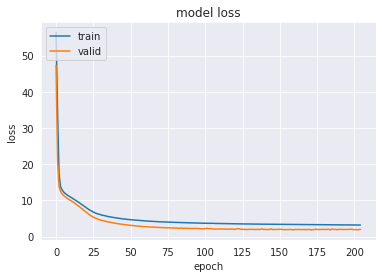

In [23]:
(history_list, 

#scores_valid_list,
scores_test_list, 

#function_values_valid_list, 
function_values_test_list, 

#polynomial_dict_valid_list,
polynomial_dict_test_list,

#distrib_dict_valid_list,
distrib_dict_test_list,

model_list) = calculate_interpretation_net_results(lambda_net_train_dataset_list, 
                                                   lambda_net_valid_dataset_list, 
                                                   lambda_net_test_dataset_list)

## Evaluate Interpretation Net

In [24]:
poly_optimize = tf.constant([float(i) for i in range(interpretation_net_output_shape)])

if interpretation_net_output_monomials != None:
    poly_optimize_coeffs = poly_optimize[:interpretation_net_output_monomials]

    poly_optimize_identifiers_list = []
    for i in range(interpretation_net_output_monomials):
        poly_optimize_identifiers = tf.math.softmax(poly_optimize[sparsity*i+interpretation_net_output_monomials:sparsity*(i+1)+interpretation_net_output_monomials])
        poly_optimize_identifiers_list.append(poly_optimize_identifiers)
    poly_optimize_identifiers_list = tf.keras.backend.flatten(poly_optimize_identifiers_list)
    poly_optimize = tf.concat([poly_optimize_coeffs, poly_optimize_identifiers_list], axis=0)


In [25]:
poly_optimize

<tf.Tensor: shape=(6,), dtype=float32, numpy=array([0., 1., 2., 3., 4., 5.], dtype=float32)>

In [26]:
if nas:
    for trial in history_list[-1]: 
        print(trial.summary())

In [27]:
if len(model_list) >= 1:
    print(model_list[-1].summary())
    print(model_list[-1].get_config())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 91)]              0         
_________________________________________________________________
hidden1_512 (Dense)          (None, 512)               47104     
_________________________________________________________________
dropout1_0.25 (Dropout)      (None, 512)               0         
_________________________________________________________________
hidden2_1024 (Dense)         (None, 1024)              525312    
_________________________________________________________________
output_1024 (Dense)          (None, 6)                 6150      
Total params: 578,566
Trainable params: 578,566
Non-trainable params: 0
_________________________________________________________________
None
{'name': 'model', 'layers': [{'class_name': 'InputLayer', 'config': {'batch_input_shape': (None, 91), 'dtype': 'floa

In [28]:
if evaluate_with_real_function:
    keys = ['inetPoly_VS_targetPoly_test', 'perNetworkPoly_VS_targetPoly_test', 'predLambda_VS_targetPoly_test', 'lstsqLambda_VS_targetPoly_test', 'lstsqTarget_VS_targetPoly_test']
else:
    keys = ['inetPoly_VS_predLambda_test', 'inetPoly_VS_lstsqLambda_test', 'perNetworkPoly_VS_predLambda_test', 'perNetworkPoly_VS_lstsqLambda_test', 'lstsqLambda_VS_predLambda_test', 'predLambda_VS_targetPoly_test']

In [29]:
scores_test_list[-1]

,MAE,RMSE,MAPE,Accuracy,Accuracy Multilabel,MAE FV,RMSE FV,MAPE FV,R2 FV,RAAE FV,RMAE FV,MEAN STD FV DIFF,MEAN FV1,MEAN FV2,STD FV1,STD FV2
lambda_preds_VS_target_polynomials,NaN,NaN,NaN,NaN,NaN,4.584,6.490,0.204,-8.093,0.893,3.158,6.233,13.106,12.979,71.848,74.535
lambda_preds_VS_lstsq_lambda_pred_polynomials,NaN,NaN,NaN,NaN,NaN,0.324,0.398,0.075,0.999,0.012,0.037,0.397,13.106,13.102,71.848,71.829
lambda_preds_VS_lstsq_target_polynomials,NaN,NaN,NaN,NaN,NaN,4.584,6.490,0.204,-8.092,0.893,3.158,6.233,13.106,12.978,71.848,74.535
lambda_preds_VS_inet_polynomials,NaN,NaN,NaN,NaN,NaN,1.712,2.155,0.185,0.860,0.158,0.311,1.881,13.106,13.176,71.848,71.503
lambda_preds_VS_symbolic_regression_functions,NaN,NaN,NaN,NaN,NaN,inf,inf,inf,-inf,inf,-inf,inf,13.106,inf,71.848,inf
lambda_preds_VS_per_network_polynomials,NaN,NaN,NaN,NaN,NaN,0.517,0.726,0.071,0.998,0.020,0.066,0.716,13.106,13.131,71.848,71.896
target_polynomials_VS_lstsq_lambda_pred_polynomials,362.704,786.520,45.028,0.000,0.000,4.549,6.463,0.161,0.757,0.257,0.660,6.203,12.979,13.102,74.535,71.829
target_polynomials_VS_lstsq_target_polynomials,1.371,2.186,0.152,0.180,0.000,0.004,0.005,0.000,1.000,0.000,0.001,0.004,12.979,12.978,74.535,74.535
target_polynomials_VS_inet_polynomials,35.922,45.694,2.125,0.002,0.000,4.915,6.626,0.250,0.749,0.272,0.606,6.158,12.979,13.176,74.535,71.503
target_polynomials_VS_symbolic_regression_functions,NaN,NaN,NaN,NaN,NaN,inf,inf,inf,-inf,inf,-inf,inf,12.979,inf,74.535,inf


In [30]:
distrib_dict_test_list[-1]['MAE']

,L-0,L-1,L-2,L-3,L-4,L-5,L-6,L-7,L-8,L-9,L-10,L-11,L-12,L-13,L-14,L-15,L-16,L-17,L-18,L-19,L-20,L-21,L-22,L-23,L-24,L-25,L-26,L-27,L-28,L-29,L-30,L-31,L-32,L-33,L-34,L-35,L-36,L-37,L-38,L-39,L-40,L-41,L-42,L-43,L-44,L-45,L-46,L-47,L-48,L-49,L-50,L-51,L-52,L-53,L-54,L-55,L-56,L-57,L-58,L-59,L-60,L-61,L-62,L-63,L-64,L-65,L-66,L-67,L-68,L-69,L-70,L-71,L-72,L-73,L-74,L-75,L-76,L-77,L-78,L-79,L-80,L-81,L-82,L-83,L-84,L-85,L-86,L-87,L-88,L-89,L-90,L-91,L-92,L-93,L-94,L-95,L-96,L-97,L-98,L-99
lambda_preds_VS_target_polynomials,1.804,3.102,4.773,1.333,7.954,6.883,3.654,1.182,2.911,5.602,3.099,3.334,1.588,5.490,10.351,1.627,5.187,1.460,1.616,1.502,1.559,1.875,9.947,5.913,2.959,2.684,1.298,1.756,0.435,2.566,3.683,5.572,18.106,1.589,5.547,1.743,2.077,5.207,22.930,0.622,1.411,6.366,0.410,7.446,3.471,2.274,1.359,2.304,1.217,0.880,1.636,3.776,2.214,9.492,2.001,2.368,10.912,6.235,8.855,1.507,7.870,0.836,2.092,10.498,15.138,6.021,12.902,1.567,4.379,8.436,10.878,0.999,2.144,5.996,1.642,2.198,17.765,6.178,3.930,4.097,2.437,2.183,2.901,5.601,9.673,2.545,1.589,2.307,2.435,2.238,4.251,7.275,0.764,3.161,3.290,11.541,2.756,13.200,1.105,2.965
lambda_preds_VS_lstsq_lambda_pred_polynomials,0.964,0.347,0.000,0.477,0.274,1.286,0.899,0.261,0.000,0.000,0.373,0.658,0.000,0.931,0.000,0.000,0.265,0.223,0.000,0.269,0.184,0.691,0.000,1.342,0.899,0.448,0.336,0.000,0.123,0.000,1.281,0.000,0.000,0.446,0.971,0.302,0.008,0.000,0.000,0.105,0.543,0.000,0.183,0.000,0.014,0.317,0.297,0.029,0.526,0.260,0.033,0.618,0.157,0.000,0.000,0.000,0.000,0.000,0.000,0.334,0.105,0.210,0.758,0.000,0.000,0.000,0.000,0.000,0.000,2.117,0.000,0.164,0.052,1.407,0.259,0.000,0.000,0.000,0.000,0.998,0.853,0.437,0.842,0.000,0.000,0.415,0.295,0.384,0.087,0.148,0.000,2.021,0.264,1.306,0.647,0.000,0.525,0.000,0.000,0.391
lambda_preds_VS_lstsq_target_polynomials,1.805,3.101,4.771,1.331,7.954,6.883,3.650,1.179,2.910,5.597,3.101,3.332,1.589,5.487,10.353,1.630,5.189,1.461,1.616,1.503,1.558,1.876,9.949,5.911,2.961,2.687,1.298,1.753,0.433,2.566,3.683,5.574,18.106,1.594,5.548,1.742,2.079,5.208,22.929,0.623,1.411,6.365,0.411,7.445,3.472,2.276,1.358,2.304,1.213,0.879,1.641,3.777,2.212,9.490,2.000,2.369,10.910,6.237,8.858,1.506,7.873,0.836,2.090,10.496,15.139,6.018,12.904,1.568,4.381,8.435,10.878,1.002,2.143,5.995,1.640,2.200,17.768,6.178,3.932,4.100,2.438,2.183,2.903,5.601,9.675,2.547,1.588,2.303,2.432,2.240,4.250,7.274,0.764,3.161,3.289,11.538,2.755,13.201,1.102,2.965
lambda_preds_VS_inet_polynomials,2.204,1.086,0.376,1.805,1.439,5.817,3.167,0.786,1.217,1.002,1.823,3.591,0.312,5.382,0.196,0.596,0.849,1.278,0.354,1.586,1.256,1.397,1.063,3.757,2.473,2.083,0.793,0.344,1.131,0.726,3.528,0.365,1.277,2.153,5.001,1.137,0.337,0.969,1.395,0.704,3.593,0.452,1.603,0.928,0.779,2.058,1.891,1.168,1.377,2.376,0.507,3.049,1.327,0.261,0.319,1.098,0.579,0.552,1.382,1.322,1.399,1.865,4.747,1.090,1.377,0.739,1.519,0.190,0.123,6.764,0.776,1.261,0.975,4.659,2.435,0.259,0.950,0.666,0.559,3.301,2.385,1.908,4.374,0.701,1.070,1.868,0.736,1.817,1.190,1.717,0.746,6.502,2.008,2.502,2.593,0.518,3.500,1.080,0.924,4.044
lambda_preds_VS_symbolic_regression_functions,1.338,2.704,0.461,0.685,1.224,inf,2.091,0.603,2.858,0.668,0.868,1.636,2.202,1.836,2.374,0.026,0.714,0.604,0.054,0.871,0.623,1.022,0.491,1.546,2.728,1.333,0.638,2.342,0.530,inf,inf,inf,1.449,3.730,inf,0.699,0.323,0.468,1.285,0.976,0.999,0.102,1.704,1.070,0.326,0.661,2.676,1.069,0.875,0.929,1.048,1.622,1.372,0.323,2.133,3.523,0.265,2.362,1.014,1.039,7.868,3.447,3.970,2.420,3.928,0.243,1.856,2.339,0.471,3.734,0.126,0.719,0.533,2.047,0.727,0.836,inf,2.357,1.047,1.774,1.217,1.022,1.699,0.306,inf,1.113,0.613,1.854,7.596,0.720,1.451,4.702,0.602,2.023,2.222,0.082,2.085,1.218,1.425,3.196
lambda_preds_VS_per_network_polynomials,1.352,0.418,0.000,0.735,0.237,1.612,1.771,0.447,0.000,0.002,0.490,1.607,0.001,1.235,0.001,0.000,0.557,0.222,0.000,0.978,0.534,0.921,0.000,1.546,1.734,1.458,0.440,0.000,0.463,0.002,1.695,0.001,0.003,0.473,1.182,0.349,0.006,0.002,0.001,0.139,0.553,0.001,0.207,0.

In [31]:
distrib_dict_test_list[-1]['R2']

,L-0,L-1,L-2,L-3,L-4,L-5,L-6,L-7,L-8,L-9,L-10,L-11,L-12,L-13,L-14,L-15,L-16,L-17,L-18,L-19,L-20,L-21,L-22,L-23,L-24,L-25,L-26,L-27,L-28,L-29,L-30,L-31,L-32,L-33,L-34,L-35,L-36,L-37,L-38,L-39,L-40,L-41,L-42,L-43,L-44,L-45,L-46,L-47,L-48,L-49,L-50,L-51,L-52,L-53,L-54,L-55,L-56,L-57,L-58,L-59,L-60,L-61,L-62,L-63,L-64,L-65,L-66,L-67,L-68,L-69,L-70,L-71,L-72,L-73,L-74,L-75,L-76,L-77,L-78,L-79,L-80,L-81,L-82,L-83,L-84,L-85,L-86,L-87,L-88,L-89,L-90,L-91,L-92,L-93,L-94,L-95,L-96,L-97,L-98,L-99
lambda_preds_VS_target_polynomials,0.948,0.942,0.741,0.962,0.779,0.983,0.963,0.991,0.985,0.931,0.965,0.990,0.961,0.957,0.550,-2.597,0.517,0.660,0.878,0.990,0.986,0.992,0.435,0.979,0.991,0.976,0.993,0.854,0.999,0.976,0.994,0.503,0.730,0.994,0.985,0.991,0.537,0.958,-0.578,0.998,0.996,-0.017,0.999,-12.783,-1.955,0.851,0.997,0.653,0.995,0.996,-8.004,0.950,0.992,-9.629,0.960,0.984,-2.222,-196.080,-31.340,0.994,-65.409,0.998,0.998,-1.089,0.763,-245.967,-65.277,0.975,0.808,0.977,0.324,0.995,-4.049,0.988,0.995,0.881,-0.203,-3.747,-6.371,0.991,0.919,0.984,0.986,0.584,-192.594,0.995,0.976,0.992,0.731,0.968,0.953,0.963,0.983,0.994,0.990,-31.839,0.992,0.861,0.992,0.996
lambda_preds_VS_lstsq_lambda_pred_polynomials,0.994,0.999,1.000,0.997,1.000,1.000,0.999,1.000,1.000,1.000,0.999,1.000,1.000,0.999,1.000,1.000,0.999,0.992,1.000,1.000,1.000,0.999,1.000,0.999,1.000,0.999,1.000,1.000,1.000,1.000,0.999,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.997,1.000,1.000,1.000,1.000,0.997,0.999,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.986,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.999,1.000,1.000,0.997,0.999,1.000,1.000,1.000,1.000,1.000,1.000,0.996,0.999,0.999,1.000,1.000,1.000,0.999,1.000,1.000,1.000,1.000,0.998,0.998,0.999,1.000,1.000,1.000,1.000,1.000,1.000
lambda_preds_VS_lstsq_target_polynomials,0.948,0.942,0.741,0.962,0.779,0.983,0.963,0.991,0.985,0.931,0.965,0.990,0.961,0.957,0.549,-2.604,0.516,0.660,0.878,0.990,0.986,0.992,0.434,0.979,0.991,0.975,0.993,0.854,0.999,0.976,0.994,0.503,0.730,0.994,0.985,0.991,0.536,0.958,-0.578,0.998,0.996,-0.017,0.999,-12.780,-1.956,0.850,0.997,0.654,0.995,0.996,-8.043,0.950,0.992,-9.626,0.961,0.984,-2.222,-196.188,-31.347,0.994,-65.439,0.998,0.998,-1.089,0.763,-245.665,-65.286,0.975,0.808,0.977,0.324,0.995,-4.049,0.988,0.995,0.881,-0.204,-3.747,-6.378,0.991,0.920,0.984,0.986,0.584,-192.683,0.995,0.976,0.992,0.731,0.968,0.953,0.963,0.983,0.994,0.990,-31.831,0.992,0.861,0.992,0.996
lambda_preds_VS_inet_polynomials,0.958,0.994,0.999,0.922,0.995,0.992,0.982,0.997,0.997,0.998,0.988,0.990,1.000,0.981,1.000,0.736,0.984,0.714,0.994,0.991,0.994,0.997,0.994,0.992,0.995,0.985,0.998,0.996,0.993,0.999,0.996,0.998,0.999,0.992,0.992,0.997,0.990,0.999,0.995,0.999,0.990,0.997,0.992,0.879,0.907,0.913,0.996,0.933,0.997,0.992,0.467,0.987,0.998,0.994,0.999,0.996,0.993,-1.091,0.590,0.997,-0.968,0.994,0.991,0.987,0.998,-2.578,0.436,1.000,1.000,0.994,0.997,0.994,0.198,0.995,0.994,0.999,0.997,0.957,0.822,0.994,0.958,0.985,0.976,0.995,-1.106,0.998,0.997,0.996,0.939,0.986,0.998,0.984,0.930,0.997,0.990,0.944,0.989,0.999,0.997,0.994
lambda_preds_VS_symbolic_regression_functions,0.984,0.972,0.999,0.990,0.997,-inf,0.986,0.998,0.989,0.999,0.998,0.998,0.981,0.996,0.986,1.000,0.990,0.946,1.000,0.997,0.999,0.997,0.999,0.999,0.981,0.992,0.998,0.875,0.999,-inf,-inf,-inf,0.999,0.629,-inf,0.997,0.994,1.000,0.997,0.998,0.999,1.000,0.995,0.880,0.986,0.991,0.841,0.961,0.998,0.998,-0.804,0.996,0.743,0.994,0.977,0.970,0.999,-20.925,0.802,0.998,-47.321,0.065,0.738,0.915,0.987,0.746,0.272,0.975,0.998,0.997,1.000,0.997,0.684,0.999,0.999,0.988,-inf,0.581,0.610,0.912,0.988,0.996,0.994,0.999,-inf,0.999,0.997,0.995,-1.076,0.997,0.995,0.990,0.989,0.998,0.991,0.999,0.994,0.999,0.996,0.996
lambda_preds_VS_per_network_polynomials,0.981,0.999,1.000,0.983,0.999,0.999,0.995,0.999,1.000,1.000,0.999,0.998,1.000,0.999,1.000,1.000,0.994,0.989,1.000,0.997,0.999,0.998,1.000,0.999,0.997,0.990,0.999,1.000,0.999,1.000,0.999,1.000,1.000,1.000

In [32]:
index_min = int(np.argmin(distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_lstsq_target_polynomials']))
polynomial_inet = polynomial_dict_test_list[-1]['inet_polynomials'][index_min]

print(distrib_dict_test_list[-1]['R2'].loc['target_polynomials_VS_inet_polynomials'][index_min])

print_polynomial_from_coefficients(polynomial_inet)

0.03470633156092651


6.16458511352539*a**1.0 - 8.54233646392822*a**2.0 - 9.01065921783447*a**3.0 + 1.37704789638519*a**4.0 + 9.34594440460205*a**5.0 + 73.1796798706055

In [33]:
index_min = int(np.argmin(distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials']))
#polynomial_target = lambda_net_test_dataset.get_lambda_net_by_lambda_index(index_min).target_polynomial

print(distrib_dict_test_list[-1]['R2'].loc['lstsq_lambda_pred_polynomials_VS_inet_polynomials'][index_min])

polynomial_lambda = lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list[index_min]
print_polynomial_from_coefficients(polynomial_lambda, force_complete_poly_representation=True)

-1.0401671333401468


1.25638297970376*a**1.0 - 86.1475230393861*a**2.0 + 223.338504168097*a**3.0 - 200.88873895886*a**4.0 + 61.6442419135415*a**5.0 - 103.719991047296

In [34]:
index_min = int(np.argmin(distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_lstsq_target_polynomials']))
#polynomial_target = lambda_net_test_dataset.get_lambda_net_by_lambda_index(index_min).target_polynomial
polynomial_target = lambda_net_test_dataset.target_polynomial_list[index_min]
print_polynomial_from_coefficients(polynomial_target, force_complete_poly_representation=True)

39.4230420687951*a**1.0 - 17.6887031529836*a**2.0 - 26.1865434514599*a**3.0 + 65.5497518936934*a**4.0 - 81.8432308696521*a**5.0 + 67.7891376481974

In [35]:
index_max = int(np.argmax(distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_lstsq_target_polynomials']))
polynomial_inet = polynomial_dict_test_list[-1]['inet_polynomials'][index_max]

print(distrib_dict_test_list[-1]['R2'].loc['target_polynomials_VS_inet_polynomials'][index_max])

print_polynomial_from_coefficients(polynomial_inet)

0.9903887759457105


-43.9689178466797*a**1.0 - 30.8534088134766*a**2.0 - 19.0365676879883*a**3.0 + 0.331412225961685*a**4.0 + 12.2492914199829*a**5.0 + 88.2688827514648

In [36]:
index_max = int(np.argmax(distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_lstsq_target_polynomials']))
#polynomial_target = lambda_net_test_dataset.get_lambda_net_by_lambda_index(index_min).target_polynomial

print(distrib_dict_test_list[-1]['R2'].loc['target_polynomials_VS_lstsq_lambda_pred_polynomials'][index_max])

polynomial_lambda = lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list[index_max]
print_polynomial_from_coefficients(polynomial_lambda, force_complete_poly_representation=True)

0.9992859271956062


-66.6595934877822*a**1.0 - 121.729271368693*a**2.0 + 359.003565316094*a**3.0 - 418.430304172527*a**4.0 + 156.875235289816*a**5.0 + 95.5228034243203

In [37]:
index_max = int(np.argmax(distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_lstsq_target_polynomials']))
#polynomial_target = lambda_net_test_dataset.get_lambda_net_by_lambda_index(index_min).target_polynomial
polynomial_target = lambda_net_test_dataset.target_polynomial_list[index_max]
print_polynomial_from_coefficients(polynomial_target, force_complete_poly_representation=True)

-79.9096219194343*a**1.0 - 10.9641571154973*a**2.0 + 7.14942889535305*a**3.0 + 51.3174873242225*a**4.0 - 62.4085665937953*a**5.0 + 95.8985975914717

In [38]:
r2_values_inet = distrib_dict_test_list[-1]['R2'].loc['target_polynomials_VS_inet_polynomials']
print('Mean: ' + str(np.mean(r2_values_inet)) + ' (' + str(r2_values_inet.shape[0]) + ' Samples)')

r2_values_positive_inet = r2_values_inet[r2_values_inet>0]
print('Mean (only positive): ' + str(np.mean(r2_values_positive_inet)) + ' (' + str(r2_values_positive_inet.shape[0]) + ' Samples)')



Mean: 0.7487691323227679 (100 Samples)
Mean (only positive): 0.825453292502448 (93 Samples)


In [39]:
r2_values_lstsq_lambda = distrib_dict_test_list[-1]['R2'].loc['target_polynomials_VS_lstsq_lambda_pred_polynomials']
print('Mean: ' + str(np.mean(r2_values_lstsq_lambda)) + ' (' + str(r2_values_inet.shape[0]) + ' Samples)')

r2_values_positive_lstsq_lambda = r2_values_lstsq_lambda[r2_values_lstsq_lambda>0]
print('Mean (only positive): ' + str(np.mean(r2_values_positive_lstsq_lambda)) + ' (' + str(r2_values_positive_lstsq_lambda.shape[0]) + ' Samples)')



Mean: 0.7570295797480058 (100 Samples)
Mean (only positive): 0.840714923696477 (92 Samples)


<AxesSubplot:xlabel='target_polynomials_VS_inet_polynomials', ylabel='Count'>

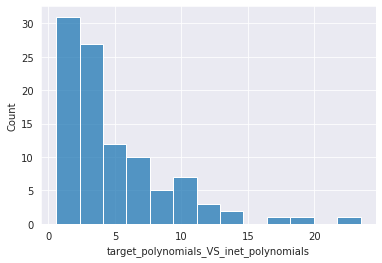

In [40]:
sns.histplot(distrib_dict_test_list[-1]['MAE'].loc['target_polynomials_VS_inet_polynomials'][distrib_dict_test_list[-1]['R2'].loc['target_polynomials_VS_inet_polynomials'] > -50])


<AxesSubplot:xlabel='target_polynomials_VS_lstsq_lambda_pred_polynomials', ylabel='Count'>

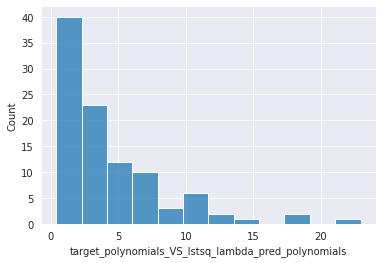

In [41]:
sns.histplot(distrib_dict_test_list[-1]['MAE'].loc['target_polynomials_VS_lstsq_lambda_pred_polynomials'][distrib_dict_test_list[-1]['R2'].loc['target_polynomials_VS_lstsq_lambda_pred_polynomials'] > -50])


[(-30.0, 1.0)]

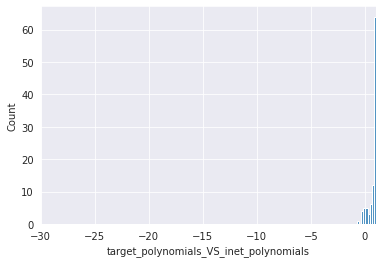

In [42]:
p = sns.histplot(distrib_dict_test_list[-1]['R2'].loc['target_polynomials_VS_inet_polynomials'][distrib_dict_test_list[-1]['R2'].loc['target_polynomials_VS_inet_polynomials'] > -50], binwidth=0.2)
p.set(xlim=(-30, 1))

[(0.0, 1.0)]

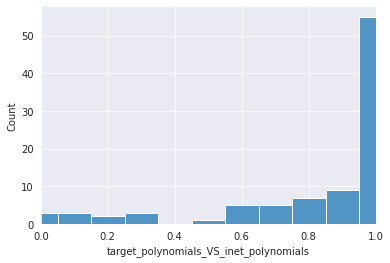

In [43]:
p = sns.histplot(distrib_dict_test_list[-1]['R2'].loc['target_polynomials_VS_inet_polynomials'][distrib_dict_test_list[-1]['R2'].loc['target_polynomials_VS_inet_polynomials'] > -50], binwidth=0.1)
p.set(xlim=(0, 1))

[(-10.0, 1.0)]

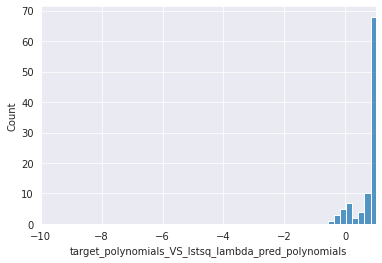

In [44]:
p = sns.histplot(distrib_dict_test_list[-1]['R2'].loc['target_polynomials_VS_lstsq_lambda_pred_polynomials'][distrib_dict_test_list[-1]['R2'].loc['target_polynomials_VS_lstsq_lambda_pred_polynomials'] > -50], binwidth=0.2)
p.set(xlim=(-10, 1))

[(0.0, 1.0)]

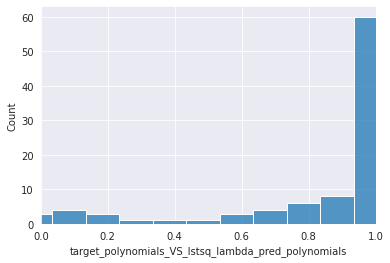

In [45]:
p = sns.histplot(distrib_dict_test_list[-1]['R2'].loc['target_polynomials_VS_lstsq_lambda_pred_polynomials'][distrib_dict_test_list[-1]['R2'].loc['target_polynomials_VS_lstsq_lambda_pred_polynomials'] > -50], binwidth=0.1)
p.set(xlim=(0, 1))

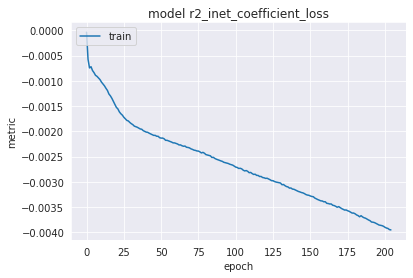

In [46]:
if not nas:
    history = history_list[-1]

    plt.plot(history[list(history.keys())[1]])
    if consider_labels_training or evaluate_with_real_function:
        plt.plot(history[list(history.keys())[len(history.keys())//2+1]]) 
    plt.title('model ' + list(history.keys())[1])
    plt.ylabel('metric')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.savefig('./data/results/' + path_identifier_interpretation_net_data + '/metric_' + '_epoch_' + str(epochs_lambda).zfill(3) + '.png')


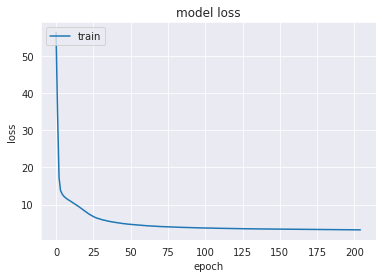

In [47]:
if not nas:
    history = history_list[-1]

    plt.plot(history['loss'])
    if consider_labels_training or evaluate_with_real_function:
        plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.savefig('./data/results/' + path_identifier_interpretation_net_data + '/loss_' + '_epoch_' + str(epochs_lambda).zfill(3) + '.png')    


### Multi Epoch/Sampes Analysis

### Generate Comparison Plots

In [48]:
if len(scores_test_list) > 1:
    plot_metric_list = ['MAE FV', 'RMSE FV', 'MAPE FV', 'R2 FV', 'RAAE FV', 'RMAE FV']

    generate_inet_comparison_plot(scores_test_list, plot_metric_list)

In [49]:
if len(scores_test_list) > 1:
    plot_metric_list = ['MAE FV']

    generate_inet_comparison_plot(scores_test_list, plot_metric_list)

In [50]:
if len(scores_test_list) > 1:
    plot_metric_list = ['R2 FV']

    generate_inet_comparison_plot(scores_test_list, plot_metric_list, ylim=(-5, 1))

#### Generate and Analyze Predictions for Random Function

In [51]:
index = 20

custom_representation_keys_fixed = ['target_polynomials', 'lstsq_target_polynomials', 'lstsq_lambda_pred_polynomials', 'lstsq_lambda_pred_polynomials']
custom_representation_keys_dynamic = ['inet_polynomials', 'per_network_polynomials']
sympy_representation_keys = ['metamodel_functions']


print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')

for key in polynomial_dict_test_list[-1].keys():
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print(key)
    if key in custom_representation_keys_fixed:
        print_polynomial_from_coefficients(polynomial_dict_test_list[-1][key][index], force_complete_poly_representation=True, round_digits=4)
    elif key in custom_representation_keys_dynamic:
        print_polynomial_from_coefficients(polynomial_dict_test_list[-1][key][index], round_digits=4)
    else:
        display(polynomial_dict_test_list[-1][key][index])

print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
lstsq_lambda_pred_polynomials


45.5317*a**1.0 - 420.6235*a**2.0 + 1006.1256*a**3.0 - 1166.6392*a**4.0 + 468.1574*a**5.0 + 8.3421

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
lstsq_target_polynomials


-72.5751*a**1.0 + 80.8179*a**2.0 - 80.5064*a**3.0 - 18.2683*a**4.0 + 7.6916*a**5.0 + 19.0553

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
target_polynomials


-72.4855*a**1.0 + 80.4794*a**2.0 - 80.1928*a**3.0 - 18.1066*a**4.0 + 7.4727*a**5.0 + 19.0483

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
inet_polynomials


-14.3221998214722*a**1.0 - 22.6128997802734*a**2.0 - 21.4958000183105*a**3.0 - 11.3431997299194*a**4.0 + 0.555400013923645*a**5.0 + 10.3762998580933

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
symbolic_regression_functions


-8.59920121742497*x**4 - 2.51096675548809*x**3 - 56.8488937266331*x**2 - 2.11001960784314*x + 9.90001610077045

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
per_network_polynomials


-9.34850025177002*a**1.0 - 34.496898651123*a**2.0 - 22.0785007476807*a**3.0 - 7.33570003509521*a**4.0 + 1.9099999666214*a**5.0 + 9.97900009155273

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


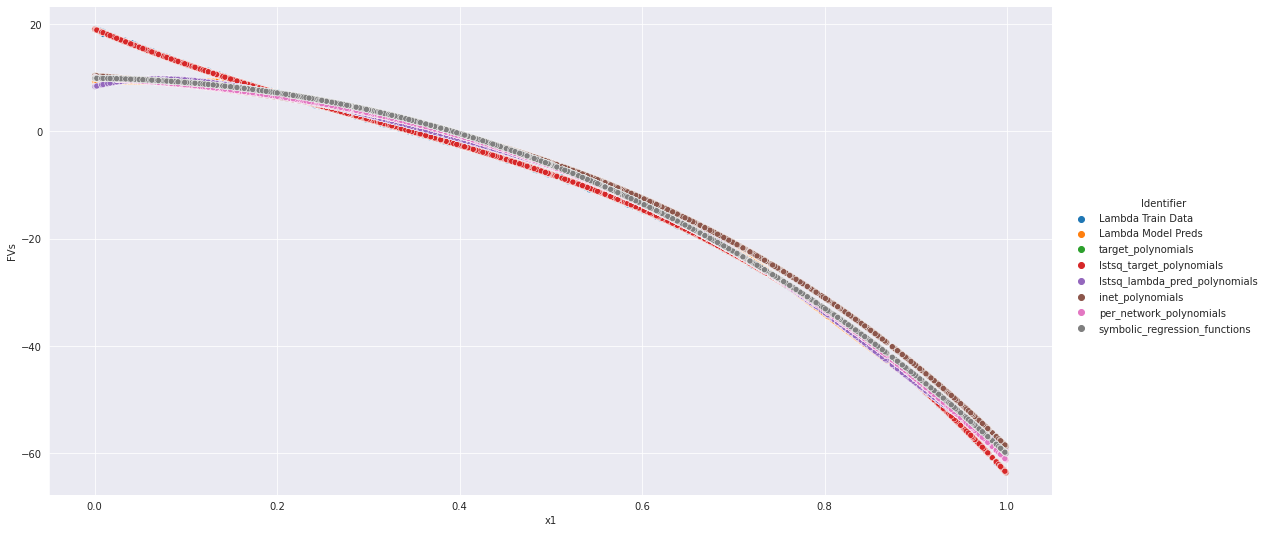

In [52]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      polynomial_dict_test_list,
                                                      rand_index=index, 
                                                      plot_type=1)

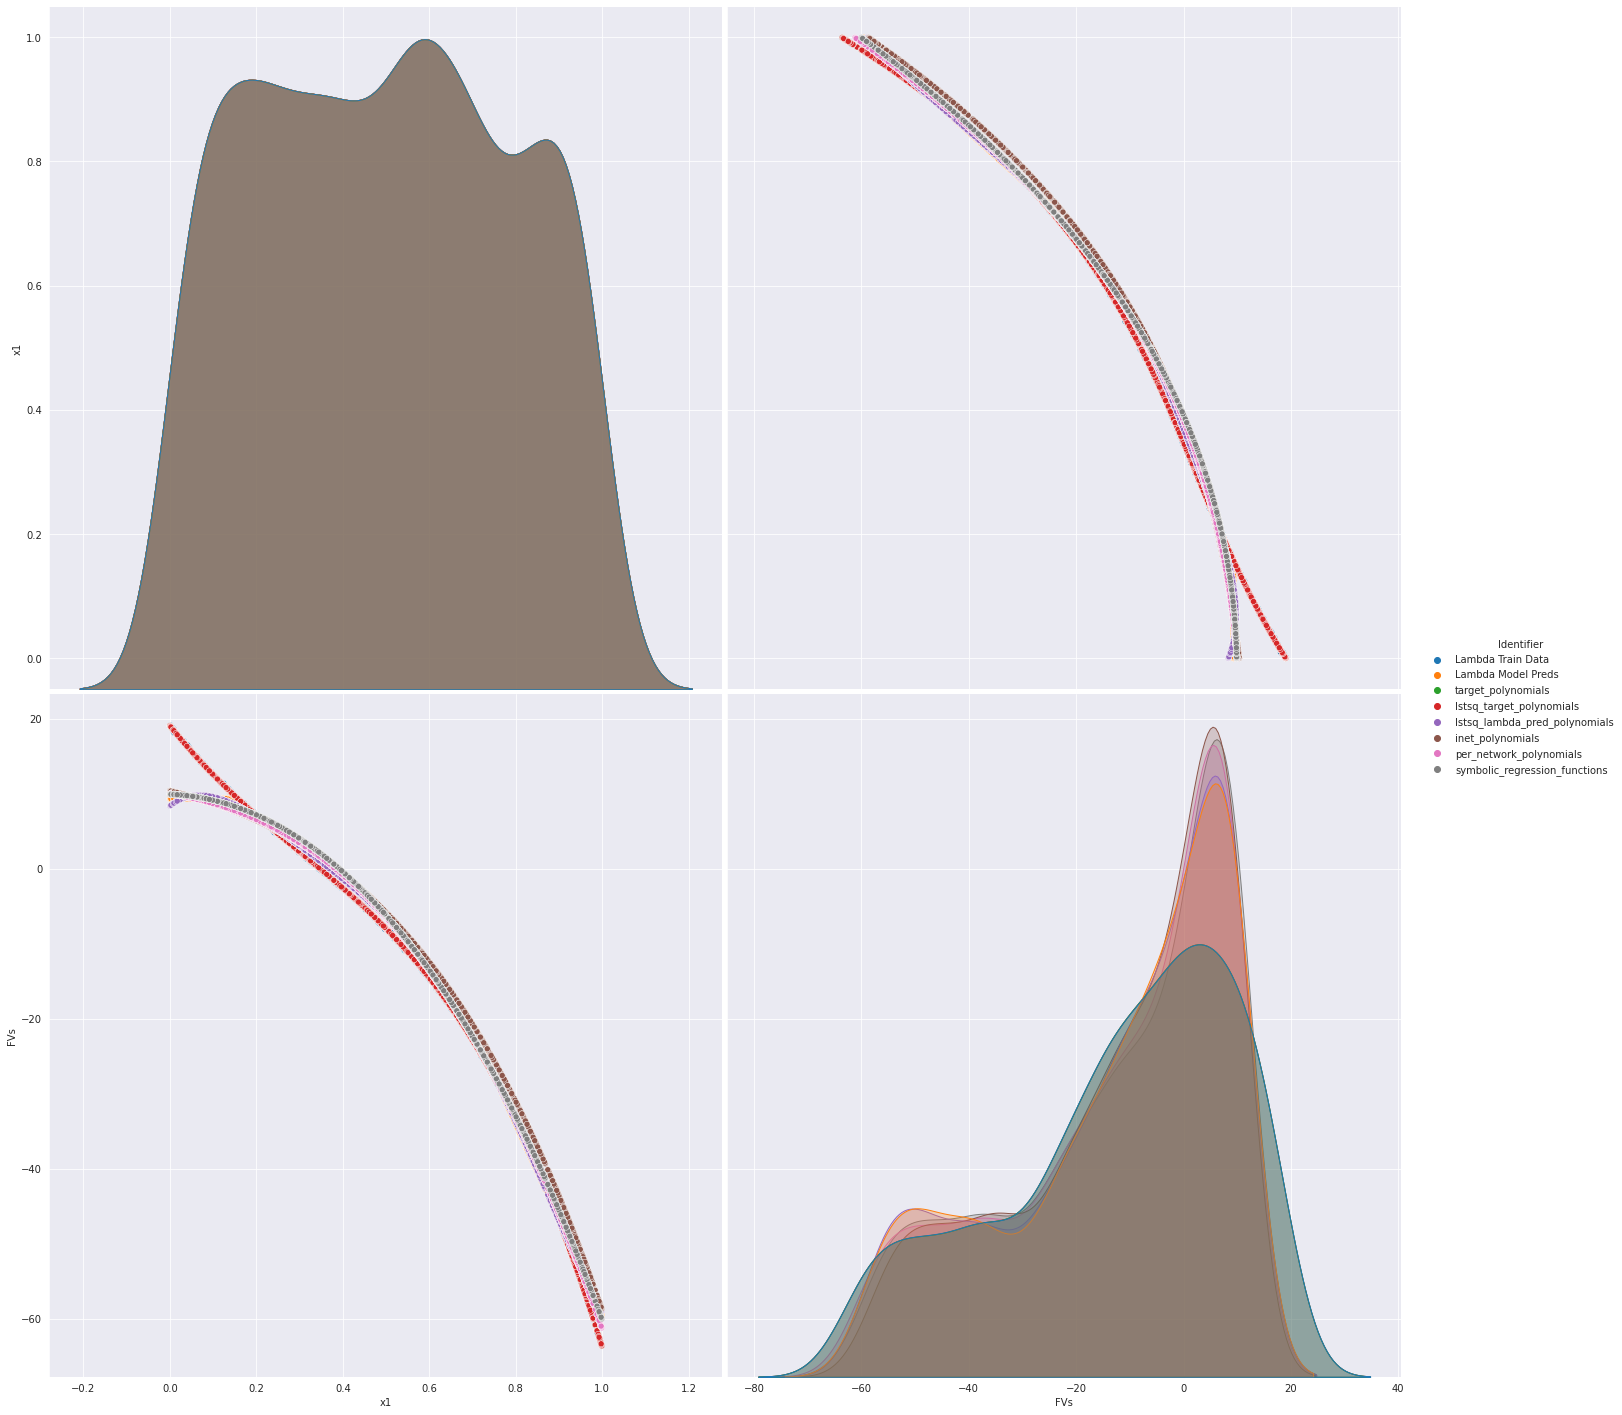

In [53]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      polynomial_dict_test_list,
                                                      rand_index=index, 
                                                      plot_type=2)

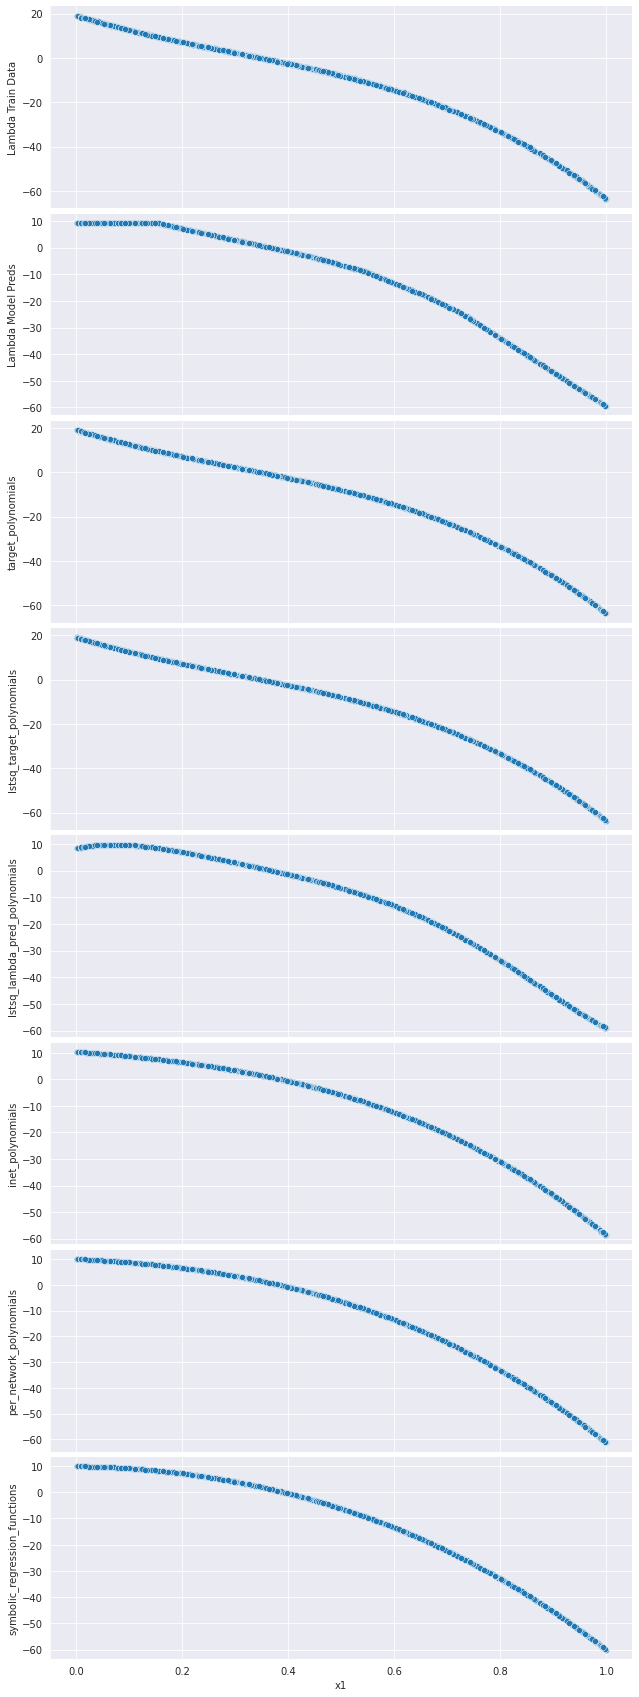

In [54]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      polynomial_dict_test_list,
                                                      rand_index=index, 
                                                      plot_type=3)

# BENCHMARK (RANDOM GUESS) EVALUATION

In [55]:
list_of_random_polynomials = np.random.uniform(low=-10, high=10, size=(len(lambda_net_test_dataset_list[-1]), sparsity))

In [56]:
true_fv_test = parallel_fv_calculation_from_polynomial(lambda_net_test_dataset_list[-1].target_polynomial_list, lambda_net_test_dataset_list[-1].X_test_data_list, force_complete_poly_representation=True)
random_fv_test = parallel_fv_calculation_from_polynomial(list_of_random_polynomials, lambda_net_test_dataset_list[-1].X_test_data_list, force_complete_poly_representation=True)

In [57]:
print('Random Guess Error Coefficients: ' + str(np.round(mean_absolute_error(lambda_net_test_dataset_list[-1].target_polynomial_list, list_of_random_polynomials), 4)))

Random Guess Error Coefficients: 49.4347


In [58]:
print('Random Guess Error FVs: ' + str(np.round(mean_absolute_error_function_values(true_fv_test, random_fv_test), 4)))

Random Guess Error FVs: 61.2385


# BENCHMARK (EDUCATED GUESS/MEAN PREDICTION) EVALUATION

In [59]:
true_fv_train = parallel_fv_calculation_from_polynomial(lambda_net_test_dataset_list[-1].target_polynomial_list, lambda_net_test_dataset_list[-1].X_test_data_list, force_complete_poly_representation=True)

mean_fv = np.mean(true_fv_train)
mean_fv_pred_test = [mean_fv for _ in range(true_fv_test.shape[0])]

In [60]:
print('Educated Guess/Mean Prediction Error FVs: ' + str(np.round(mean_absolute_error_function_values(true_fv_test, mean_fv_pred_test), 4)))

Educated Guess/Mean Prediction Error FVs: 60.7427


In [61]:
%%script false --no-raise-error

base_model = generate_base_model()
random_evaluation_dataset = np.random.uniform(low=x_min, high=x_max, size=(random_evaluation_dataset_size, n))
#random_evaluation_dataset = lambda_train_input_train_split[0]#lambda_train_input[0] #JUST [0] HERE BECAUSE EVALUATION ALWAYS ON THE SAME DATASET FOR ALL!!
list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)


loss_function = mean_absolute_error_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model)      

X_train = X_train_list[-1].values[:,1:]
y_train = y_train_list[-1].values[:,2:]

#X_train = X_train[:,1:]
y_train_model = np.hstack((y_train, X_train))

print('seed_in_inet_training = ' + str(seed_in_inet_training), loss_function(y_train_model, y_train))


seed_in_inet_training = False

loss_function = mean_absolute_error_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model)      

X_train = X_train_list[-1].values[:,1:]
y_train = y_train_list[-1].values[:,2:]

X_train = X_train[:,1:]
y_train_model = np.hstack((y_train, X_train))

print('seed_in_inet_training = ' + str(seed_in_inet_training), loss_function(y_train_model, y_train))

seed_in_inet_training = True



In [62]:
#%load_ext autoreload

In [63]:
#%autoreload 2
lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
current_jobs = 1

lr=0.5
max_steps = 100
early_stopping=10
restarts=2
per_network_dataset_size = 500

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  

if n_jobs != -1:
    n_jobs_per_network = min(n_jobs, os.cpu_count() // current_jobs)
else: 
    n_jobs_per_network = os.cpu_count() // current_jobs - 1

printing = True if n_jobs_per_network == 1 else False


lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)
if evaluate_with_real_function: #target polynomial as inet target
    poly_representation_list = np.array(lambda_net_test_dataset.target_polynomial_list)
else: #lstsq lambda pred polynomial as inet target
    poly_representation_list = np.array(lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list)


config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         #'list_of_monomial_identifiers': list_of_monomial_identifiers,
         'x_min': x_min,
         'x_max': x_max,
         }


lambda_network_weights = lambda_network_weights_list[0]
poly_representation = poly_representation_list[0]


per_network_poly_optimization_tf(per_network_dataset_size, 
                                lambda_network_weights, 
                                  list_of_monomial_identifiers_numbers, 
                                  config, 
                                  lr=lr, 
                                  max_steps = max_steps, 
                                  early_stopping=early_stopping, 
                                  restarts=restarts, 
                                  printing=True)


Current best: 6.822996616363525 
 Curr_res: 6.7554240226745605 
 Iteration 1, Step 99
Optimization terminated at 6.7554240226745605


array([-13.738747, -31.376099, -21.821865,   8.568817,  28.910652,
        37.190063], dtype=float32)

# Evaluate Real Dataset


##  Auto MPG-Dataset

In [64]:
interpretation_possible_autoMPG = False
print_head_autoMPG = None

url_autoMPG = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names_autoMPG = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset_autoMPG = pd.read_csv(url_autoMPG, names=column_names_autoMPG,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

dataset_autoMPG = raw_dataset_autoMPG.dropna()

dataset_autoMPG['Origin'] = dataset_autoMPG['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
dataset_autoMPG = pd.get_dummies(dataset_autoMPG, columns=['Origin'], prefix='', prefix_sep='')


features_autoMPG = dataset_autoMPG.copy()

labels_autoMPG = features_autoMPG.pop('MPG')

features_autoMPG_normalized = (features_autoMPG-features_autoMPG.min())/(features_autoMPG.max()-features_autoMPG.min())


if features_autoMPG_normalized.shape[1] >= n:
    if n == 1:
        features_autoMPG_model = features_autoMPG_normalized[['Horsepower']]
    elif n == train_features_normalized.shape[1]:
        features_autoMPG_model = features_autoMPG_normalized
    else:
        features_autoMPG_model = features_autoMPG_normalized.sample(n=n, axis='columns')
        
    print_head_autoMPG = features_autoMPG_model.head()
    interpretation_possible_autoMPG = True

print_head_autoMPG

,Horsepower
0,0.457
1,0.647
2,0.565
3,0.565
4,0.511


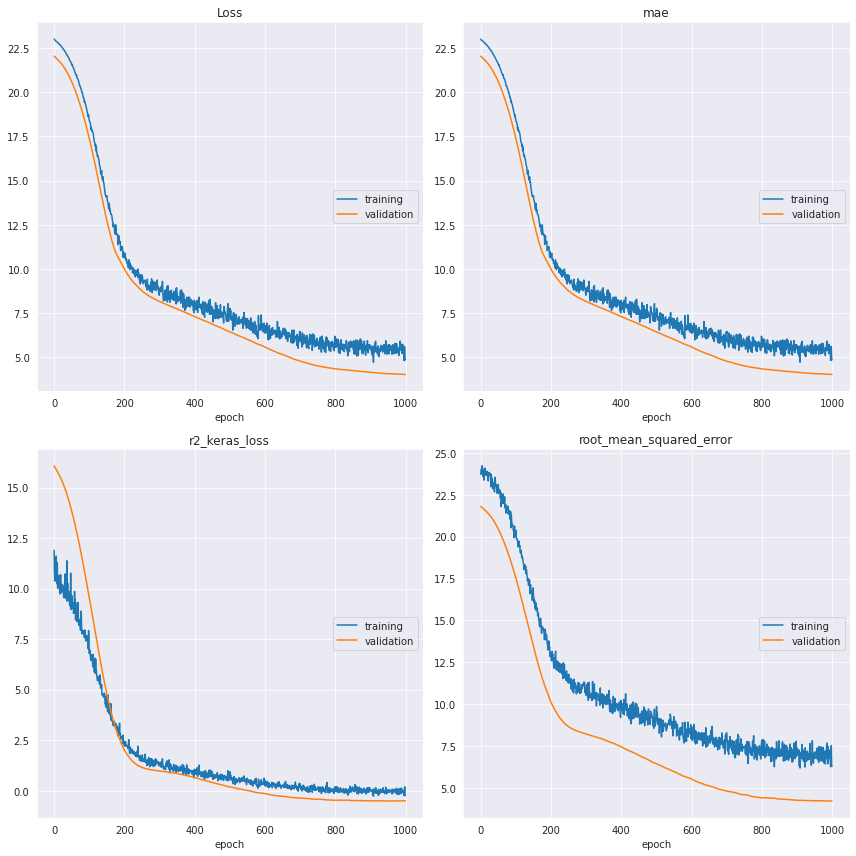

Loss
	training         	 (min:    4.734, max:   23.006, cur:    4.869)
	validation       	 (min:    4.042, max:   22.045, cur:    4.042)
mae
	training         	 (min:    4.734, max:   23.006, cur:    4.869)
	validation       	 (min:    4.042, max:   22.045, cur:    4.042)
r2_keras_loss
	training         	 (min:   -0.269, max:   11.899, cur:   -0.246)
	validation       	 (min:   -0.511, max:   16.082, cur:   -0.501)
root_mean_squared_error
	training         	 (min:    6.184, max:   24.236, cur:    6.275)
	validation       	 (min:    4.214, max:   21.804, cur:    4.223)


In [77]:
#%autoreload 2
if interpretation_possible_autoMPG:
    ((lambda_index_autoMPG, 
     current_seed_autoMPG, 
     polynomial_autoMPG, 
     polynomial_lstsq_pred_list_autoMPG, 
     polynomial_lstsq_true_list_autoMPG), 
    scores_list_autoMPG, 
    pred_list_autoMPG, 
    history_autoMPG, 
    model_autoMPG) = train_nn(lambda_index=0, 
                              X_data_lambda=features_autoMPG_model.values, 
                              y_data_real_lambda=labels_autoMPG.values, 
                              polynomial=None, 
                              seed_list=[5], 
                              callbacks=[PlotLossesKerasTF()], 
                              return_history=True, 
                              each_epochs_save=None, 
                              printing=False, 
                              return_model=True)
    
    polynomial_lstsq_pred_autoMPG = polynomial_lstsq_pred_list_autoMPG[-1]

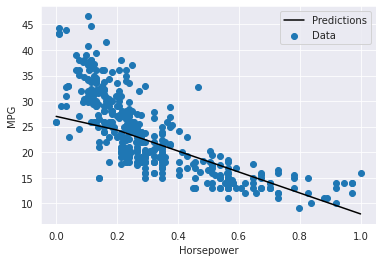

In [78]:
if interpretation_possible_autoMPG:
    x = tf.linspace(0.0, 1, 250)#tf.linspace(0.0, 250, 251)
    y = model_autoMPG.predict(x)

    plt.scatter(features_autoMPG_model['Horsepower'], labels_autoMPG, label='Data')
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel('Horsepower')
    plt.ylabel('MPG')
    plt.legend()

In [79]:
config = {
        'n': n,
        'd': d,
        'inet_loss': inet_loss,
        'sparsity': sparsity,
        'lambda_network_layers': lambda_network_layers,
        'interpretation_net_output_shape': interpretation_net_output_shape,
        'RANDOM_SEED': RANDOM_SEED,
        'nas': nas,
        'number_of_lambda_weights': number_of_lambda_weights,
        'interpretation_net_output_monomials': interpretation_net_output_monomials,
        'fixed_initialization_lambda_training': fixed_initialization_lambda_training,
        'dropout': dropout,
        'lambda_network_layers': lambda_network_layers,
        'optimizer_lambda': optimizer_lambda,
        'loss_lambda': loss_lambda,        
         #'list_of_monomial_identifiers': list_of_monomial_identifiers,
         'x_min': x_min,
         'x_max': x_max,
         }

weights_autoMPG = model_autoMPG.get_weights()

weights_flat_autoMPG = []
for layer_weights, biases in pairwise(weights_autoMPG):    #clf.get_weights()
    for neuron in layer_weights:
        for weight in neuron:
            weights_flat_autoMPG.append(weight)
    for bias in biases:
        weights_flat_autoMPG.append(bias)
        
weights_flat_autoMPG = np.array(weights_flat_autoMPG)

x = pred_list_autoMPG['X_test_lambda']
y = pred_list_autoMPG['y_test_real_lambda']

y_model_autoMPG = model_autoMPG.predict(x)




In [80]:
if interpretation_possible_autoMPG:
    y_polynomial_lstsq_pred_autoMPG = calculate_function_values_from_polynomial(polynomial_lstsq_pred_autoMPG, x, force_complete_poly_representation=True)

    mae_model_polynomial_lstsq_pred_autoMPGy = mean_absolute_error(y_model_autoMPG, y_polynomial_lstsq_pred_autoMPG)
    mae_data_polynomial_lstsq_pred_autoMPG = mean_absolute_error(y, y_polynomial_lstsq_pred_autoMPG)

    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('LSTSQt Poly:')
    print_polynomial_from_coefficients(y_polynomial_lstsq_pred_autoMPG, force_complete_poly_representation=True)
    print('MAE Model: ', mae_model_polynomial_lstsq_pred_autoMPGy)
    print('MAE Data: ', mae_data_polynomial_lstsq_pred_autoMPG)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
LSTSQt Poly:


23.2729963026133*a**1.0 + 25.3376384390714*a**2.0 + 25.4194718319049*a**3.0 + 17.9606584979872*a**4.0 + 24.4550009347111*a**5.0 + 16.8307084620871

MAE Model:  0.05775680099395369
MAE Data:  5.173040664220301
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [81]:
if interpretation_possible_autoMPG:
    interpretation_net = model_list[-1]
    
    start = time.time() 
    
    interpretation_net_poly = interpretation_net.predict(np.array([weights_flat_autoMPG]))[0]
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    y_interpretation_net_poly = calculate_function_values_from_polynomial(interpretation_net_poly, x, force_complete_poly_representation=False)
    
    mae_model_interpretation_net_poly = mean_absolute_error(y_model_autoMPG, y_interpretation_net_poly)
    mae_data_interpretation_net_poly = mean_absolute_error(y, y_interpretation_net_poly)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Interpretation Net Poly:')
    print_polynomial_from_coefficients(interpretation_net_poly, force_complete_poly_representation=False)
    print('MAE Model: ', mae_model_interpretation_net_poly)
    print('MAE Data: ', mae_data_interpretation_net_poly)    
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Interpretation Net Poly:


9.29431629180908*a**1.0 + 6.35017585754395*a**2.0 + 8.91285514831543*a**3.0 + 9.6754322052002*a**4.0 + 6.29675531387329*a**5.0 + 10.047384262085

MAE Model:  10.526280792020662
MAE Data:  14.30468448369229
Computation Time: 0:00:00
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [82]:
if interpretation_possible_autoMPG:
    start = time.time() 
    
    if False:
        per_network_hyperparams = {
            'optimizer':  'Powell',
            'jac': 'fprime',
            'max_steps': 5000,#100,
            'restarts': 3,
            'per_network_dataset_size': 500,
        }      
        
        per_network_function =  per_network_poly_optimization_scipy(per_network_dataset_size, 
                                                                  weights_flat_autoMPG, 
                                                                  list_of_monomial_identifiers_numbers, 
                                                                  config, 
                                                                  optimizer = per_network_hyperparams['optimizer'],
                                                                  jac = per_network_hyperparams['jac'],
                                                                  max_steps = per_network_hyperparams['max_steps'], 
                                                                  restarts=per_network_hyperparams['restarts'], 
                                                                  printing=True,
                                                                  return_error=False)
    else:
        per_network_hyperparams = {
            'optimizer': tf.keras.optimizers.RMSprop,
            'lr': 0.02,
            'max_steps': 500,
            'early_stopping': 10,
            'restarts': 3,
            'per_network_dataset_size': 5000,
        }   
        
        per_network_function =  per_network_poly_optimization_tf(per_network_hyperparams['per_network_dataset_size'], 
                                                              weights_flat_autoMPG, 
                                                              list_of_monomial_identifiers_numbers, 
                                                              config, 
                                                              optimizer = per_network_hyperparams['optimizer'],
                                                              lr=per_network_hyperparams['lr'], 
                                                              max_steps = per_network_hyperparams['max_steps'], 
                                                              early_stopping=per_network_hyperparams['early_stopping'], 
                                                              restarts=per_network_hyperparams['restarts'], 
                                                              printing=True,
                                                              return_error=False)
            
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)  
    
    y_per_network_function = calculate_function_values_from_polynomial(per_network_function, x, force_complete_poly_representation=False)
    
    mae_model_interpretation_net_poly = mean_absolute_error(y_model_autoMPG, y_per_network_function)
    mae_data_interpretation_net_poly = mean_absolute_error(y, y_per_network_function)    
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Per Network Poly:')
    print_polynomial_from_coefficients(per_network_function)
    print('MAE Model: ', mae_model_interpretation_net_poly)
    print('MAE Data: ', mae_data_interpretation_net_poly)       
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


Current best: 5.598620891571045 
 Curr_res: 5.5866804122924805 
 Iteration 2, Step 499
Optimization terminated at 5.385234355926514
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Per Network Poly:


9.87221717834473*a**1.0 + 1.08275890350342*a**2.0 - 4.66499519348145*a**3.0 - 5.40198564529419*a**4.0 - 5.79644346237183*a**5.0 + 11.0095930099487

MAE Model:  9.022723684307502
MAE Data:  12.39385310107056
Computation Time: 0:00:21
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [83]:
if interpretation_possible_autoMPG:
    
    symbolic_regression_hyperparams = {
        'dataset_size': 500,
    }

    start = time.time() 
    
    symbolic_regression_function =  symbolic_regression(model_autoMPG, 
                                                      config,
                                                      symbolic_regression_hyperparams,
                                                      #printing = True,
                                                      return_error = False)
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    y_symbolic_regression_function = calculate_function_values_from_sympy(symbolic_regression_function, x)
    
    mae_model_symbolic_regression_function = mean_absolute_error(y_model_autoMPG, y_symbolic_regression_function)
    mae_data_symbolic_regression_function = mean_absolute_error(y, y_symbolic_regression_function)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Symbolic Regression Poly:')    
    display(symbolic_regression_function)
    print('MAE Model: ', mae_model_symbolic_regression_function)
    print('MAE Data: ', mae_data_symbolic_regression_function)      
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    48.81          15458.8       63           3.8497           3.3653      4.40m
   1    33.79          658.131       63          1.88717          1.69067      2.85m
   2    45.87          67.9366       63          1.56007          1.31776      3.29m
   3    48.12          123.619       51          1.03331          1.04308      3.15m
   4    60.74          50.4195       53         0.310977         0.387373      3.31m
   5    61.87          47.4629       49         0.295632         0.525471      3.06m
   6    58.49          41.0632       43         0.200042         0.259265      2.77m
   7    52.27          22.4076       67         0.126431         0.155413      2.38m
   8    47.81          42.9782       67         0.131936         0.105869  

-(x - 1.167)*(x + 19.6978461538462) + 4.38378723404255

MAE Model:  0.396831271761022
MAE Data:  5.250315832662823
Computation Time: 0:03:19
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [84]:
#%autoreload 2
if interpretation_possible_autoMPG:
    metamodeling_hyperparams = {
        'num_iter': 500,
        'batch_size': None,
        'learning_rate': 0.01,        
        'dataset_size': 500,
    }
    
    start = time.time() 

    metamodel_function =  symbolic_metamodeling(model_autoMPG, 
                                              config,
                                              metamodeling_hyperparams,
                                              #printing = True,
                                              return_error = False,
                                              return_expression = 'approx', #'approx', #'exact',
                                              function_metamodeling = False,
                                              force_polynomial=False)
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    y_metamodel_function = calculate_function_values_from_sympy(metamodel_function, x)
    
    mae_model_metamodel_function = mean_absolute_error(y_model_autoMPG, y_metamodel_function)
    mae_data_metamodel_function = mean_absolute_error(y, y_metamodel_function)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Metamodel Function:')    
    display(metamodel_function)
    print('MAE Model: ', mae_model_metamodel_function)
    print('MAE Data: ', mae_data_metamodel_function)      
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

---- Tuning the basis functions ----


  0%|          | 0/1 [00:00<?, ?it/s]

a, b, c 2 1 1
a, b, c 1.5288297056400308 1.1683714976839017 2.284850521439836
a, b, c 1.5288297056400308 1.1683714976839017 2.284850521439836
----  Optimizing the metamodel  ----


  0%|          | 0/500 [00:00<?, ?it/s]

a, b, c 1.0641607291818502 1.875310121013833 3.1816871801325797
a, b, c -1.4480484152901436 26.211589578824352 33.051236251387984
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Metamodel Function:


1/(1.92792414828793e+1564283084927009179516377050*exp(-2.16347240915216e+28*X0**5 + 6.68513664081517e+28*X0**4 - 8.62194962274556e+28*X0**3 + 5.89429643629317e+28*X0**2 - 2.18490283216216e+28*X0) + 1)

MAE Model:  22.260911707975428
MAE Data:  25.30816326530612
Computation Time: 0:00:05
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [85]:
if interpretation_possible_autoMPG and False:
    metamodeling_hyperparams = {
        'num_iter': 500,
        'batch_size': None,
        'learning_rate': 0.01,        
        'dataset_size': 500,
    }
    
    start = time.time() 

    metamodel_function_basic =  symbolic_metamodeling(model_autoMPG, 
                                              config,
                                              metamodeling_hyperparams,
                                              #printing = True,
                                              return_error = False,
                                              return_expression = 'approx', #'approx', #'exact',
                                              function_metamodeling = True,
                                              force_polynomial=False)
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    y_metamodel_function_basic = calculate_function_values_from_sympy(metamodel_function_basic, x)
    
    mae_metamodel_function_basic = mean_absolute_error(y_model_autoMPG, y_metamodel_function_basic)
    mae_metamodel_function_basic = mean_absolute_error(y, y_metamodel_function_basic)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Metamodel Function Basic:')    
    display(metamodel_function_basic)
    print('MAE Model: ', mae_metamodel_function_basic)
    print('MAE Data: ', mae_metamodel_function_basic)      
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

In [86]:
if interpretation_possible_autoMPG:
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Interpretation Net Poly:')
    print_polynomial_from_coefficients(interpretation_net_poly, force_complete_poly_representation=False)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Per Network Poly:')
    print_polynomial_from_coefficients(per_network_function, force_complete_poly_representation=False)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('LSTSQ Poly:')
    print_polynomial_from_coefficients(polynomial_lstsq_pred_autoMPG, force_complete_poly_representation=True)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Symbolic Regression Function:')
    display(symbolic_regression_function)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Metamodel Function:')
    display(metamodel_function)
    #print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    #print('Metamodel Function Basic:')
    #display(metamodel_function_basic)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Interpretation Net Poly:


9.29431629180908*a**1.0 + 6.35017585754395*a**2.0 + 8.91285514831543*a**3.0 + 9.6754322052002*a**4.0 + 6.29675531387329*a**5.0 + 10.047384262085

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Per Network Poly:


9.87221717834473*a**1.0 + 1.08275890350342*a**2.0 - 4.66499519348145*a**3.0 - 5.40198564529419*a**4.0 - 5.79644346237183*a**5.0 + 11.0095930099487

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
LSTSQ Poly:


-7.44531974260415*a**1.0 - 38.730399036014*a**2.0 + 51.6980441927137*a**3.0 - 30.9127596730575*a**4.0 + 6.41999366536805*a**5.0 + 26.8616776799131

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Symbolic Regression Function:


-(x - 1.167)*(x + 19.6978461538462) + 4.38378723404255

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Metamodel Function:


1/(1.92792414828793e+1564283084927009179516377050*exp(-2.16347240915216e+28*X0**5 + 6.68513664081517e+28*X0**4 - 8.62194962274556e+28*X0**3 + 5.89429643629317e+28*X0**2 - 2.18490283216216e+28*X0) + 1)

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


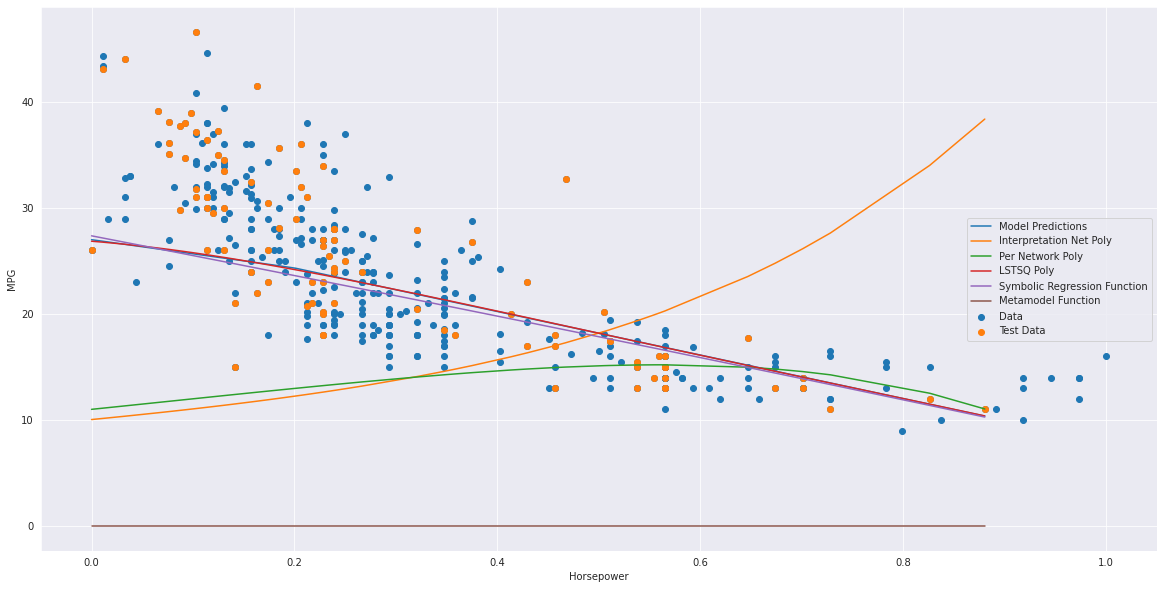

In [87]:
if interpretation_possible_autoMPG:
    fig, ax = plt.subplots(1, 1, figsize=(20,10))
    
    plt.scatter(features_autoMPG_model['Horsepower'], labels_autoMPG, label='Data')
    plt.scatter(x, y, label='Test Data')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_model_autoMPG))]) , label='Model Predictions')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_interpretation_net_poly))]) , label='Interpretation Net Poly')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_per_network_function))]) , label='Per Network Poly')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_polynomial_lstsq_pred_autoMPG))]) , label='LSTSQ Poly')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_symbolic_regression_function))]) , label='Symbolic Regression Function')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_metamodel_function))]) , label='Metamodel Function')
    #plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y))]) y_metamodel_function_basic, label='Metamodel Function Basic')
    plt.xlabel('Horsepower')
    plt.ylabel('MPG')
    plt.legend()

In [76]:
    #Plot Polynom, lamdba net, and Interpration net
    length_plt = len(plot_metric_list)
    if length_plt >= 2:
        fig, ax = plt.subplots(length_plt//2, 2, figsize=(30,20))
    else:
        fig, ax = plt.subplots(1, 1, figsize=(20,10))

    for index, metric in enumerate(plot_metric_list):
        
        plot_scores_dict = {}
        for key in evaluation_key_list:
            try:
                scores_list[-1][metric].loc[key]
                plot_scores_dict[key] = []
            except:
                #print(key + 'not in scores_list')
                continue
            
        
        for scores in scores_list:
            for key in evaluation_key_list:
                try:
                    plot_scores_dict[key].append(scores[metric].loc[key])
                except:
                    #print(key + 'not in scores_list')
                    continue
                                        
            
        plot_df = pd.DataFrame(data=np.vstack(plot_scores_dict.values()).T, 
                               index=x_axis_steps,
                               columns=plot_scores_dict.keys())

        if length_plt >= 2:
            ax[index//2, index%2].set_title(metric)
            sns.set(font_scale = 1.25)
            p = sns.lineplot(data=plot_df, ax=ax[index//2, index%2])
        else:
            ax.set_title(metric)
            sns.set(font_scale = 1.25)
            p = sns.lineplot(data=plot_df, ax=ax)

        if ylim != None:
            p.set(ylim=ylim)

        p.set_yticklabels(np.round(p.get_yticks(), 2), size = 20)
        p.set_xticklabels(p.get_xticks(), size = 20)     
        
        #p.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        p.legend(loc='upper center', bbox_to_anchor=(0.47, -0.1),
          fancybox=False, shadow=False, ncol=2, fontsize=12)   
        
    plt.subplots_adjust(wspace=0.1, hspace=0.75)

NameError: name 'plot_metric_list' is not defined

# Evaluate Per-Network Poly Optimization

## Example Optimization (Common Optimizer)

In [ ]:
random_index = RANDOM_SEED

per_network_hyperparams = {
    'optimizer':  'Powell',
    'jac': 'fprime',
    'max_steps': 5000,#100,
    'restarts': 3,
    'per_network_dataset_size': 500,
}

lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)
lambda_network_weights = lambda_network_weights_list[random_index]

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  

printing = True

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }


per_network_optimization_error, per_network_optimization_polynomial = per_network_poly_optimization_scipy(per_network_hyperparams['per_network_dataset_size'], 
                                                                                                      lambda_network_weights, 
                                                                                                      list_of_monomial_identifiers_numbers, 
                                                                                                      config,
                                                                                                      optimizer = per_network_hyperparams['optimizer'],
                                                                                                      jac = per_network_hyperparams['jac'],
                                                                                                      max_steps = per_network_hyperparams['max_steps'], 
                                                                                                      restarts = per_network_hyperparams['restarts'],
                                                                                                      printing = True,
                                                                                                      return_error = True)

print('\n\nError: ' + str(per_network_optimization_error))
print_polynomial_from_coefficients(per_network_optimization_polynomial)



## Example Optimization (Neural Optimizer)

In [ ]:
random_index = RANDOM_SEED

per_network_hyperparams = {
    'optimizer': tf.keras.optimizers.RMSprop,
    'lr': 0.02,
    'max_steps': 500,
    'early_stopping': 10,
    'restarts': 3,
    'per_network_dataset_size': 5000,
}

lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)
lambda_network_weights = lambda_network_weights_list[random_index]

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  

printing = True

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }


per_network_optimization_error, per_network_optimization_polynomial = per_network_poly_optimization_tf(per_network_hyperparams['per_network_dataset_size'], 
                                                                                                      lambda_network_weights, 
                                                                                                      list_of_monomial_identifiers_numbers, 
                                                                                                      config,
                                                                                                      optimizer = per_network_hyperparams['optimizer'],
                                                                                                      lr = per_network_hyperparams['lr'], 
                                                                                                      max_steps = per_network_hyperparams['max_steps'], 
                                                                                                      early_stopping = per_network_hyperparams['early_stopping'], 
                                                                                                      restarts = per_network_hyperparams['restarts'],
                                                                                                      printing = True,
                                                                                                      return_error = True)

print('\n\nError: ' + str(per_network_optimization_error.numpy()))
print_polynomial_from_coefficients(per_network_optimization_polynomial)



## Grid Search Common Optimizers

In [ ]:
%%script false --no-raise-error

pd.set_option('max_colwidth', 100)

evaluation_size = 10

per_network_hyperparams = {
    'optimizer':  [
                   'Nelder-Mead', 
                   'Powell', 
        
                   'CG',
                   'BFGS',
                   'Newton-CG', 
                   #'L-BFGS-B', #'>' not supported between instances of 'int' and 'NoneType'
                   'TNC', 
                   
                   'COBYLA', 
                   'SLSQP', 
                   
                   #'trust-constr', # TypeError: _minimize_trustregion_constr() got an unexpected keyword argument 'maxfun'
                   #'dogleg', # ValueError: Hessian is required for dogleg minimization
                   #'trust-ncg', #ValueError: Either the Hessian or the Hessian-vector product is required for Newton-CG trust-region minimization
                   #'trust-exact', # ValueError: Hessian matrix is required for trust region exact minimization.
                   #'trust-krylov' #ValueError: Either the Hessian or the Hessian-vector product is required for Krylov trust-region minimization
                   ], 
    'jac': ['fprime'],
    'max_steps': [5000],#100,
    'restarts': [3],
    'per_network_dataset_size': [500],
}

#param_iterator = ParameterSampler(per_network_hyperparams, n_iter=60, random_state=RANDOM_SEED)
param_iterator = ParameterGrid(per_network_hyperparams)


lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  
printing = True if n_jobs == 1 else False

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }

In [ ]:
%%script false --no-raise-error

params_error_list = []
for params in tqdm(param_iterator):
    parallel_per_network = Parallel(n_jobs=n_jobs, verbose=0, backend='loky')

    result_list = parallel_per_network(delayed(per_network_poly_optimization_scipy)(params['per_network_dataset_size'], 
                                                                                  lambda_network_weights, 
                                                                                  list_of_monomial_identifiers_numbers, 
                                                                                  config,
                                                                                  optimizer = params['optimizer'],
                                                                                  jac = params['jac'],
                                                                                  max_steps = params['max_steps'], 
                                                                                  restarts = params['restarts'],
                                                                                  printing = printing,
                                                                                  return_error = True) for lambda_network_weights in lambda_network_weights_list[:evaluation_size])  
    
    
    per_network_optimization_errors = [result[0] for result in result_list]
    per_network_optimization_polynomials = [result[1] for result in result_list]
        
    params_score = np.mean(per_network_optimization_errors)
    
    evaluation_result = list(params.values())
    evaluation_result.append(params_score)
    
    params_error_list.append(evaluation_result)
        
    del parallel_per_network

columns = list(params.keys())
columns.append('score')
params_error_df = pd.DataFrame(data=params_error_list, columns=columns).sort_values(by='score')
params_error_df.head(10) 

## Grid Search Neural Optimizers

In [ ]:
%%script false --no-raise-error

pd.set_option('max_colwidth', 100)

evaluation_size = 100

per_network_hyperparams = {
    'optimizer': [tf.keras.optimizers.RMSprop], #[tf.keras.optimizers.SGD, tf.optimizers.Adam, tf.keras.optimizers.RMSprop, tf.keras.optimizers.Adadelta]
    'lr': [0.02], #[0.5, 0.25, 0.1, 0.05, 0.025]
    'max_steps': [5000],#100,
    'early_stopping': [10],
    'restarts': [3],
    'per_network_dataset_size': [5000],
}

#param_iterator = ParameterSampler(per_network_hyperparams, n_iter=60, random_state=RANDOM_SEED)
param_iterator = ParameterGrid(per_network_hyperparams)


lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  
printing = True if n_jobs == 1 else False

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }

In [ ]:
%%script false --no-raise-error

params_error_list = []
for params in tqdm(param_iterator):
    parallel_per_network = Parallel(n_jobs=n_jobs, verbose=0, backend='loky')

    result_list = parallel_per_network(delayed(per_network_poly_optimization_tf)(params['per_network_dataset_size'], 
                                                                                  lambda_network_weights, 
                                                                                  list_of_monomial_identifiers_numbers, 
                                                                                  config,
                                                                                  optimizer = params['optimizer'],
                                                                                  lr = params['lr'], 
                                                                                  max_steps = params['max_steps'], 
                                                                                  early_stopping = params['early_stopping'], 
                                                                                  restarts = params['restarts'],
                                                                                  printing = printing,
                                                                                  return_error = True) for lambda_network_weights in lambda_network_weights_list[:evaluation_size])  
    
    
    per_network_optimization_errors = [result[0] for result in result_list]
    per_network_optimization_polynomials = [result[1] for result in result_list]
        
    params_score = np.mean(per_network_optimization_errors)
    
    evaluation_result = list(params.values())
    evaluation_result.append(params_score)
    
    params_error_list.append(evaluation_result)
        
    del parallel_per_network

columns = list(params.keys())
columns.append('score')
params_error_df = pd.DataFrame(data=params_error_list, columns=columns).sort_values(by='score')
params_error_df.head(10) 

In [ ]:
if use_gpu:
    from numba import cuda 
    device = cuda.get_current_device()
    device.reset()